# Progetto data Analytics

## Installing libraries

In [1]:
#for install libraries
!sudo apt install build-essential python-dev libxml2 libxml2-dev zlib1g-dev
!sudo pip install cairocffi
!pip install python-igraph
!pip install louvain

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python-dev is already the newest version (2.7.15~rc1-1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libxml2 is already the newest version (2.9.4+dfsg1-6.1ubuntu1.2).
libxml2 set to manually installed.
libxml2-dev is already the newest version (2.9.4+dfsg1-6.1ubuntu1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     |████████████████████████████████| 71kB 4.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/e7/5d/6f/fc3c2364dfd3c4cfd15d786b156077c52209d9af45496fdf12
Successfully built cairocffi
     |████████████████████████████████| 378kB 5.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eeba

#### Execute this only if you are Alex Caselli on Colab

In [2]:
from google.colab import drive
import networkx as nx
import igraph as ig
import louvain
from collections import OrderedDict
import numpy as np
from tqdm import tqdm_notebook as tqdm
drive.mount('/content/gdrive')
baseURL = '/content/gdrive/My Drive/Data Analytics/';

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import Libraries and set local path

In [0]:
import networkx as nx
import igraph as ig
import louvain
from collections import OrderedDict
import numpy as np
import csv
from tqdm import tqdm_notebook as tqdm

baseURL = '../'

# Creation of a dictionaty for maintain all nets
Create a dictionary of lists, the key rappresents the day (start 0 end 29), the list is a list of nets about the specific day with this order: (attackGraph, messageGraph, TradeGraph, allianceGraph, allGraph, compactallGraph)

In [3]:

# our structure 
allNetwork = dict()

nGraph = 30

# for structure graphs inserting
attackGraph = ig.Graph(directed=True)
messageGraph = ig.Graph(directed=True)
tradeGraph = ig.Graph(directed=True)
totalGraph = ig.Graph(directed=True)
allianceGraph = ig.Graph(directed=True)
compactAllGraph = ig.Graph(directed=True)

for i in tqdm(range(0, nGraph)):
    # print("Day: ", (i + 1))
    
    # read all needed graphs
    attackGraph = attackGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Compact/AttackGraph/cAttack-2009-12-"+str(i+1)+".graphml")
    messageGraph = messageGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Compact/MessageGraph/cMessage-2009-12-"+str(i+1)+".graphml")
    tradeGraph = tradeGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Compact/TradeGraph/cTrade-2009-12-"+str(i+1)+".graphml")
    allianceGraph = allianceGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Compact/AllianceGraph/cAlliance-2009-12-"+str(i+1)+".graphml")
    totalGraph = totalGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Compact/TotalGraph/cTotal-2009-12-"+str(i+1)+".graphml")
    
    # put as a list in a dictionary 
    allNetwork[i] = (attackGraph, messageGraph, tradeGraph, allianceGraph, totalGraph) 
    
# tricksterAnalysis(allNetwork)

# for i in tqdm(range(0, len(allNetwork))):
#    for j in tqdm(range(0, len(allNetwork[i]))):
        # print(allNetwork[i][4].summary())
#        addCommunitiesLabel(allNetwork[i][j], i)
        # print(allNetwork[i][4].summary())
# print("")

# This below cell will be use for any kind of check about nets, variables, indexes; for this reason no one comments are required

In [0]:
print(len(allNetwork[0][0].vs))
# 3861


cont = 0
communityContIndegree = 0
for i in range(0, len(allNetwork)):
    for vertex in allNetwork[i][4].vs:
        if vertex['id'] == '2':
            print("{:>20}{:>3}".format("PRESENT IN THE DAY:", str(i + 1)))
            print("{:>20}{:>3}".format("DAY INDEGREE: ", vertex.indegree()))
            print("{:>20}{:>3}".format("DAY OUTDEGREE: ", vertex.outdegree()))     
            print("{:>20}{:>3}".format("COMMUNITY: ", vertex['Community'])) 
            for edge in allNetwork[i][4].es:
                if allNetwork[i][4].vs[edge.tuple[0]]['id'] == '2':
                    if edge['Label'] == 'Attack' and allNetwork[i][4].vs[edge.tuple[1]]['id'] == '4878':
                        print("DIOCANE: ", edge['Weight'])
                    if edge['Label'] == 'Trade':
                        cont += edge['Weight']
                    print("{:>20}{:>3}".format("OUTDEGREE LABEL: ", edge['Label']))
                    print("{:>20}{:>3}".format("QUANTITY: ", edge['Weight']))
                if allNetwork[i][4].vs[edge.tuple[1]]['id'] == '2':
                    if allNetwork[i][4].vs[edge.tuple[0]]['Community'] == allNetwork[i][4].vs[edge.tuple[1]]['Community'] and i == 26:
                        communityContIndegree += 1
                    print("{:>20}{:>3}".format("INDEGREE LABEL: ", edge['Label']))
                    print("{:>20}{:>3}".format("QUANTITY: ", edge['Weight']))
            print("") 
print(cont)
print("COMMUNITY CONT INDEGREE: ", communityContIndegree)

# vertex = allNetwork[1][4].vs.select(id = "10935")
# print(vertex['id'])
# print(vertex['Community'])
    
'''for i in range(0, len(allNetwork)):
    print("DAY: "+str(i+1))
    for edge in allNetwork[i][4].es:
        if allNetwork[i][4].vs[edge.tuple[0]]['id'] == '2789':
            print(edge)
print("")
for i in range(0, len(allNetwork)):
    print("DAY: "+str(i+1))
    for edge in allNetwork[i][4].es:
        if allNetwork[i][4].vs[edge.tuple[1]]['id'] == '2789':
            print(edge)'''


# 11850

### Domande da fare
**1)** Il numero massimo e minimo di nodi, dato il paper, è corretto e ci torna; il numero minimo e massimo di archi invece no. Il fatto è molto strano perché noi semplicemente apriamo il file graphml e stampiamo le info associate. Lavoriamo facendo finta di nulla? <br>
1) è stato detto di fregarsene, l'importante è che si usi o il file gml oppure il csv, non bisogna usare entrambi

**2)** Abbiamo osservato come, dato il file di community e la rete totale (attack + trade + message), non tutti i nodi sono presenti in questo file. Indagando su questi abbiamo poi osservato che subiscono (nella maggior parte dei casi) attacchi. Possiamo quindi dedurre che si tratti effettivamente di nodi non affiliati a nessuna alleanza in quanto utenti che hanno smesso di giocare o stanno iniziando a giocare (alcuni non subiscono attacchi ma commerciano e attaccano, scudo prottetivo 30 giorni, punteggio minimo giocare)? <br>
2) è normale in quanto le community segnate sono quelle registrate dagli utenti stessi sul server, quindi è possibile che alcuni nodi non siano affiliati a nessuna alleanza

**3)** Le misure di centralità sono possibili per reti multigrafo? <br>
**4)** In cosa differisce la presentazione dalla demo? <br>
**5)** Le community di dimensione minore di 10 come possiamo tratterle in maniera intelligente? Le associamo tutte a uno stesso identificativo, le eliminiamo, che facciamo? <br>

### Nuove domande
**1)** Va bene il modus con cui abbiamo fatto il diametro? Sono corretti questi valori? He senso mettere il peso degli archi? Anche per la edge betweens ha senso?<br>
**2)** Va bene il grado medio? Va bene impostare dei range per la distribuzione di grado? <br>
**3)** Come faccio a calcolare il coefficiente di clustering? <br>
**4)** Far vedere la demo + presentazione, chiedere se dobbiamo consegnare comunque una presentazione per dare un'idea della corposità <br>
**5** Dato lo studio della community ha senso eliminare i nodi che non hanno, dato il giorno, attività interne alla community? (Far vedere immagini). <br>




# START ANALYSIS !!!!

### Users number trend in the 30 days

In [0]:
def userNumberTrend(allNetwork):
    nUsers = [0]*len(allNetwork)
    for i in range(0, len(allNetwork)):
        nUsers[i] = allNetwork[i][4].vcount()

    print("Users in the 30 days: ", nUsers)
    print("")
    print("{:>53}{:>7}.".format("Average users number in the 30 days is: ", round(sum(nUsers)/len(nUsers)), 2))
    print("{:>53}{:>7}.".format("The maximum number of users was recorded on the day: ", nUsers.index(max(nUsers))+1))
    print("")
    return nUsers


def userCommunityNumberTrend(communityStory):
    nUsers = [0]*len(communityStory)
    with open(baseURL+'Dash/SingleCommunityStudy/CSVFILE/nUserTrend.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['day', 'quantity'])
        
        for i in range(0, len(communityStory)):
            nUsers[i] = communityStory[i].vcount()
            filewriter.writerow([i+1, communityStory[i].vcount()])
        


    print("Users in the 30 days: ", nUsers)
    print("")
    print("{:>53}{:>7}.".format("Average users number in the 30 days is: ", round(sum(nUsers)/len(nUsers)), 2))
    print("{:>53}{:>7}.".format("The maximum number of users was recorded on the day: ", nUsers.index(max(nUsers))+1))
        
    print("")
    #return nUsers

### Edges number trend in the 30 days

In [0]:
def edgeNumberTrend(allNetwork):  
    nAttack = [0]*len(allNetwork)
    nTrade = [0]*len(allNetwork)
    nMessage = [0]*len(allNetwork)

    for i in range(0, nGraph):
        for edge in allNetwork[i][4].es:
            if edge['Label'] == "Attack":
                nAttack[i] += edge['Weight']
            elif edge['Label'] == "Trade":
                nTrade[i] += edge['Weight']
            elif edge['Label'] == "Message":
                nMessage[i] += edge['Weight']
            else:
                print("This is a problem...")

    print("{:>33}".format("Number of attacks in the 30 days:"), end = " ")
    print(nAttack)
    print("")
    print("{:>32}".format("Number of trades in the 30 days:"), end = " ")
    print(nTrade)
    print("")
    print("{:>34}".format("Number of messages in the 30 days:"), end = " ")
    print(nMessage)
    print("")
    print("{:>40}{:>9}".format("Average number of attacks in 30 days:", sum(nAttack)/len(nAttack)))
    print("{:>40}{:>9}".format("Average number of trades a in 30 days:", round(sum(nTrade)/len(nTrade), 1)))
    print("{:>40}{:>9}".format("Average number of messages a in 30 days:", round(sum(nMessage)/len(nMessage), 1)))  
    print("")
    print("{:>40}{:>9}".format("Day with the highest number of attacks:", nAttack.index(max(nAttack))+1))
    print("{:>40}{:>9}".format("Day with the highest number of trades:", nTrade.index(max(nTrade))+1))
    print("{:>40}{:>9}".format("Day with the highest number of messages:", nMessage.index(max(nMessage))+1)) 
    print("")
    
    return nAttack, nTrade, nMessage


def edgeCommunityNumberTrend(communityStory):
    nTrade = [0]*len(communityStory)
    nMessage = [0]*len(communityStory)
    
    with open(baseURL+'Dash/SingleCommunityStudy/CSVFILE/nEdgeTrend.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['day', 'type', 'quantity'])
    
        for i in range(0, len(communityStory)):
            for edge in communityStory[i].es:
                nTrade[i] += edge['TWeight']
                nMessage[i] += edge['MWeight']
            filewriter.writerow([i+1, 'nMessage', nMessage[i]])
            filewriter.writerow([i+1, 'nTrade', nTrade[i]])
                
    print("{:>32}".format("Number of trades in the 30 days:"), end = " ")
    print(nTrade)
    print("")
    print("{:>34}".format("Number of messages in the 30 days:"), end = " ")
    print(nMessage)
    print("")
    print("{:>40}{:>9}".format("Average number of trades a in 30 days:", round(sum(nTrade)/len(nTrade), 1)))
    print("{:>40}{:>9}".format("Average number of messages a in 30 days:", round(sum(nMessage)/len(nMessage), 1)))  
    print("")
    print("{:>40}{:>9}".format("Day with the highest number of trades:", nTrade.index(max(nTrade))+1))
    print("{:>40}{:>9}".format("Day with the highest number of messages:", nMessage.index(max(nMessage))+1)) 
    print("")  

Code for generate a csv with edge and nodes trends in 30days

In [0]:
nAttack, nTrade, nMessage=edgeNumberTrend(allNetwork)
nUsers=userNumberTrend(allNetwork)


#write trend in a CSV
with open(baseURL+'Dash/userAndEdge_trends_30days.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['day', 'type', 'quantity'])
    
    for i in range(1, 30):
        filewriter.writerow([i, 'nUsers',nUsers[i]])
        filewriter.writerow([i, 'nAttack',nAttack[i]])
        filewriter.writerow([i, 'nTrade',nTrade[i]])
        filewriter.writerow([i, 'nMessage',nMessage[i]])
        
with open(baseURL+'Dash/edgesTrend.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['day', 'type', 'quantity'])
    
    for i in range(1, 30):
        filewriter.writerow([i, 'nAttack',nAttack[i]])
        filewriter.writerow([i, 'nTrade',nTrade[i]])
        filewriter.writerow([i, 'nMessage',nMessage[i]])

Number of attacks in the 30 days: [32997.0, 32782.0, 30264.0, 23883.0, 18748.0, 22424.0, 23448.0, 22550.0, 22401.0, 22778.0, 22162.0, 21628.0, 20675.0, 22086.0, 19969.0, 22134.0, 22367.0, 21772.0, 18820.0, 18390.0, 18771.0, 16970.0, 16477.0, 16467.0, 15715.0, 18164.0, 17230.0, 17057.0, 16513.0, 16749.0]

Number of trades in the 30 days: [9390.0, 8710.0, 8667.0, 8545.0, 9499.0, 9799.0, 9638.0, 8806.0, 8698.0, 8921.0, 9008.0, 9310.0, 9298.0, 9834.0, 10175.0, 9866.0, 9884.0, 9008.0, 8624.0, 8314.0, 8443.0, 8981.0, 8062.0, 8659.0, 8054.0, 8436.0, 9062.0, 8665.0, 8606.0, 8521.0]

Number of messages in the 30 days: [15831.0, 14600.0, 14847.0, 12765.0, 14852.0, 14141.0, 13978.0, 14166.0, 15675.0, 14122.0, 12030.0, 14045.0, 14207.0, 12767.0, 11405.0, 13180.0, 11979.0, 12482.0, 14510.0, 10314.0, 11110.0, 13327.0, 12889.0, 11486.0, 7996.0, 7697.0, 9071.0, 8631.0, 7388.0, 8214.0]

   Average number of attacks in 30 days:  21079.7
  Average number of trades a in 30 days:   8982.8
Average number of

### Trickster detection tool 
This tool is designed for identifying dishonest users who manage two accounts and use one for the main account. The assumption is: if i see you two times do more trading than any else action you are a suspected and is necessary to see what are you done in the period (30 days). 

In [0]:
# Main function call all function that compose the tool
def tricksterAnalysis(allNetwork):
    
    # make a list with main suspect for every day, in the end we have a following structure
    #{DAY: {idSuspected: {idBeneficiry: qta}}} 
    # a dictionary where for first external key we have a day, inside 1 lvl key is suspected id, in the last 2 lvl
    # a dictionary of beneficiary key with quantity of trading
    dailySuspicions = dict()
    print("Start trickester Analysis")
    print("Watching for dishonest user in the period...")
    for i in tqdm(range(0, len(allNetwork))):
        # print("DAY: ", str(i+1))
        dailySuspicions[i] = tricksterDetectionTool(allNetwork[i][4])
    
    # from first skimming compute a guilty index and print the player with more then 0.3 on index
    edgesCount(printRealSuspected(dailySuspicions, len(dailySuspicions)), allNetwork)

# create a day dictionary structur (see below)
def tricksterDetectionTool(totalNet):
    zeroIndegreeVertex = list()

    # get, specific net, all vertex with 0 indegree
    for vertex in totalNet.vs:
        if vertex.indegree() == 0:
            zeroIndegreeVertex.append(vertex)
    
    '''for vertex in zeroIndegreeVertex:
        print(vertex)
        print(vertex.indegree())
        print(vertex.outdegree())'''
    # print(zeroIndegreeVertex)
    
    # create a dictionary for keeping suspects with respective beneficiary
    suspecteds = dict()
    beneficiary = dict()
    key = ""
    
    # for every zero indegree vertex count the number of edge and the number of trade edge
    # if find a trade edge save the beneficiary of this trade and quantity
    for vertex in zeroIndegreeVertex:
        nEdges = 0
        nTrades = 0
        key = ""
        beneficiary = dict()
        for edge in totalNet.es:
            if totalNet.vs[edge.tuple[0]]['id'] == vertex['id']:
                nEdges += edge['Weight']
                if edge['Label'] == 'Trade':
                #    if totalNet.vs[edge.tuple[0]]['id'] == vertex['id'] == "7855":
                #        print(edge)
                    # print(totalNet.vs[edge.tuple[0]]['id'])
                    # print(vertex['id'])
                    if totalNet.vs[edge.tuple[1]]['id'] in beneficiary:
                        beneficiary[totalNet.vs[edge.tuple[1]]['id']] += edge['Weight']
                    else:
                        beneficiary[totalNet.vs[edge.tuple[1]]['id']] = edge['Weight']
                    nTrades += edge['Weight']
        # if the trades edges number is more than 95%, the node is suspected, saved it!
        if nTrades/nEdges >= 0.95:
            # print(nEdges)
            # print(nTrades)
            key = str(vertex['id'])
            # print(key)
            # print(beneficiary)
            suspecteds[key] = beneficiary
    
    # for key in suspecteds:
    #    print(key, suspecteds[key])
    return suspecteds    

# from all day suspects we want a more compact structure for see what happen to our suspects node in the period
# (30 days). The structure is a dictionary: 
# {idSuspected: [nWatchTimes, {idBeneficiary: [nWatchTimes, qnt]}, nWatchSuspectAsBeneficiary, qnt]}
# from this we can delete from suspects list the node with only one appearance
def printRealSuspected(allSuspects, nDays):
    
    print("Compact recovered information...")
    beneficiaries = dict()
    suspectsSummary = dict()
    finalSuspects = dict()
    
    
    for day in allSuspects:
        for suspect in allSuspects[day]:
            # print("Suspected: ", suspect)
            # increase the number of nWatchTimes about suspects
            if str(suspect) in suspectsSummary:
                suspectsSummary[suspect][0] += 1
            else:
                suspectsSummary[suspect] = list([1, dict(), 0, 0])
                suspectsSummary[suspect][0] = 1
                # print(suspectsSummary[suspect][0])
            # print("TIME: ", suspectsSummary[suspect])
            
            # for all suspect beneficiary increase nWatchTimes about beneficiary and qnt about trade
            for beneficiary in allSuspects[day][suspect]:
                # print("Beneficiary is: ", beneficiary)
                # print("Benefit is: ", allSuspects[day][suspect][beneficiary])
                # print(str(beneficiary) in suspectsSummary[suspect][1])
                if str(beneficiary) in suspectsSummary[suspect][1]:
                    suspectsSummary[suspect][1][beneficiary][0] += 1
                    suspectsSummary[suspect][1][beneficiary][1] += allSuspects[day][suspect][beneficiary]
                else:
                    suspectsSummary[suspect][1][beneficiary] = [1, allSuspects[day][suspect][beneficiary]]

                    
            # print(suspectsSummary)

    # increase nWatchSuspectAsBeneficiary qnt index
    for day in allSuspects:
        for suspect in allSuspects[day]:
            for beneficiary in allSuspects[day][suspect]:
                if beneficiary in suspectsSummary:
                    # print("HERE MAN")
                    suspectsSummary[beneficiary][2] += 1
                    suspectsSummary[beneficiary][3] += allSuspects[day][suspect][beneficiary]
                    # print(suspectsSummary[beneficiary])
                    
            # print(suspectsSummary)
            # print("")
                
    # suspectsSummary = sorted(suspectsSummary.items(), key=lambda e: e[1][2])
    # order from the most observed to the least observed 
    suspectsSummary = OrderedDict(sorted(suspectsSummary.items(), key=lambda t: t[1][0], reverse=True))
    
    # print("Complete: ", len(suspectsSummary))
    # for suspect in suspectsSummary:
    #    print(suspect, suspectsSummary[suspect])
    
    # if suspect is observed only one time or is observed as many times as there are beneficiaries; 
    # is no longer a suspect
    for suspect in suspectsSummary:
        if suspectsSummary[suspect][0] > 1 and suspectsSummary[suspect][0] != suspectsSummary[suspect][2]:
            finalSuspects[suspect] = suspectsSummary[suspect]
            
    # print("With elimination: ", len(finalSuspects))
    # for suspect in finalSuspects:
        # print(suspect, finalSuspects[suspect])
    
    # print("")
    # print(finalSuspects)
    
    return finalSuspects
 
# compute a Guiltyindex (based to experimental observations) and print the node with more than .3
def edgesCount(finalSuspects, allNet):
    print("This are the main suspects!")
    edgesInCount = dict()
    edgesOutCount = dict()
    tradeEdgesInCount = dict()
    edgesOutPlayer = dict()
    finalResult = dict()
 
    activityDay = list()
    attackDay = list()
    tradeDay = list()
    
    inCount = 0
    outCount = 0
    tradeOutCount = 0
    tradeInCount = 0
    guiltyIndex = 0
    maxIndex = 0
    cont = 0
    
    
    # count number of edge about all typology
    for suspect in finalSuspects:
        
        activityDay.clear()
        attackDay.clear()
        tradeDay.clear()
        
        edgesInCount.clear()
        edgesOutCount.clear()
        edgesOutPlayer.clear()
        tradeEdgesInCount.clear()
        
        
        for i in range(0, 3):
            edgesInCount['Attack'] = 0
            edgesInCount['Trade'] = 0
            edgesInCount['Message'] = 0
            edgesOutCount['Attack'] = 0
            edgesOutCount['Trade'] = 0
            edgesOutCount['Message'] = 0
        
        inCount = 0
        outCount = 0
        tradeOutCount = 0
        tradeInCount = 0
        guiltyIndex = 0
        
        # append a activity day of suspect
        for day in allNet:
            for vertex in allNet[day][4].vs:
                if str(vertex['id']) == suspect:
                    activityDay.append(str(day+1))
            

            for edge in allNet[day][4].es:
                if allNetwork[day][4].vs[edge.tuple[0]]['id'] == suspect:
                    if edge['Label'] in edgesOutCount:
                        edgesOutCount[edge['Label']] += edge['Weight']
                    else:
                        edgesOutCount[edge['Label']] = edge['Weight']
                    if edge['Label'] == 'Trade':
                        if allNetwork[day][4].vs[edge.tuple[1]]['id'] in edgesOutPlayer:
                            edgesOutPlayer[allNetwork[day][4].vs[edge.tuple[1]]['id']] += edge['Weight']
                        else:
                            edgesOutPlayer[allNetwork[day][4].vs[edge.tuple[1]]['id']] = edge['Weight']
                        if (day + 1) not in tradeDay:
                            tradeDay.append(day + 1)
                if allNet[day][4].vs[edge.tuple[1]]['id'] == suspect:
                    if edge['Label'] == 'Trade':
                        if allNet[day][4].vs[edge.tuple[0]]['id'] in tradeEdgesInCount:
                            tradeEdgesInCount[allNetwork[day][4].vs[edge.tuple[0]]['id']] += edge['Weight']
                        else:
                            tradeEdgesInCount[allNetwork[day][4].vs[edge.tuple[0]]['id']] = edge['Weight']
                    if edge['Label'] in edgesInCount:
                        edgesInCount[edge['Label']] += edge['Weight']
                    else:
                        edgesInCount[edge['Label']] = edge['Weight']
                    if edge['Label'] == 'Attack':
                        if (day + 1) not in attackDay:
                            attackDay.append(day + 1)
        guiltyIndex = edgesOutCount['Trade']*((1/len(edgesOutPlayer)))*1.3
        # print("Trade out: ", edgesOutCount['Trade'])
        # print("People Served: ", len(edgesOutPlayer))
        # print(guiltyIndex)
        guiltyIndex -= (edgesInCount['Trade']*5)
        # print(guiltyIndex)
        guiltyIndex -= (edgesOutCount['Message'])*1
        # print(guiltyIndex)
        guiltyIndex += (edgesInCount['Message'])*0.3
        # print(guiltyIndex)
        guiltyIndex -= edgesOutCount['Attack']*0.4
        # print(guiltyIndex)
        guiltyIndex -= edgesInCount['Attack']*0.08
        # print(guiltyIndex)
        # print("DENOMINATOR: ", edgesInCount['Attack']+edgesInCount['Trade']+edgesInCount['Message']+edgesOutCount['Attack']+edgesOutCount['Message']+edgesOutCount['Trade'])
        guiltyIndex = guiltyIndex / (edgesInCount['Attack']*0.08+edgesInCount['Trade']+edgesInCount['Message']+edgesOutCount['Attack']+edgesOutCount['Message']*2+edgesOutCount['Trade'])
        if guiltyIndex >= 0.3:
            if guiltyIndex > maxIndex:
                maxIndex = guiltyIndex
            print("GULTY INDEX: ", round(guiltyIndex, 4))
            print("SUSPECT: ", suspect)
            print("EDGES IN: ", edgesInCount)
            print("EDGES OUT: ", edgesOutCount)
            print("PLAYER SERVED: ", edgesOutPlayer)
            print("ACTIVITY DAYS: ", activityDay)
            print("DAYS OF ATTACKS SUFFERED: ", attackDay)
            print("DAYS OF TRADE DONE: ", tradeDay)
            print("PLAYER TRADE WITH SUSPECT: ", tradeEdgesInCount)
            print(" ")
            
            value = [0]*8
            finalResult[suspect] = list([0, dict(), dict(), dict(), dict(), list(), list(), dict()])
            finalResult[suspect][0] = round(round(guiltyIndex, 4), 3)
            finalResult[suspect][1] = edgesInCount
            finalResult[suspect][2] = edgesInCount
            finalResult[suspect][3] = edgesOutCount
            finalResult[suspect][4] = edgesOutPlayer
            finalResult[suspect][5] = activityDay
            finalResult[suspect][6] = attackDay
            finalResult[suspect][7] = tradeEdgesInCount
            cont += 1
            
    for suspect in finalResult:
        print(suspect)
        finalResult[suspect][0] = finalResult[suspect][0]/maxIndex
        print(finalResult[suspect])
    
    
    print(cont)

## Communities Dynamics

#### Add communities label to vertex

In [0]:
def addCommunitiesLabel(allCompactNetwork, dayCommunity):
        
    # print("DAY: ", (dayCommunity+1))
    communities = open(baseURL +  "Dataset/Communities/OrganizedCommunities/Ocommunities-2009-12-"+str(dayCommunity + 1)+".txt", "r")
    
    communityCont = 0
    nNodes = 0
    nNodesPresent = 0
    nDissolved = 0
    nActive = 0
    
    present = False
    
    communityAffiliates = dict()
    
    affiliatesNodes = list()
    noMatchNodes = list()
    nodesGraphNoMatch = list()
    vertexToDelete = list()
    
    for line in communities:
        # print("COMMUNITY NUMBER: ", cont)
        # print(line)
        line = line.split()
        # print(type(line[0]))
        for node in line:
            if node == "DISSOLVED":
                nDissolved += 1
                affiliatesNodes.append("DISSOLVED")
                continue
            present = False
            nNodes += 1
            # allCompactNetwork.vs.select('id' = node)['Community'] = communityCont
            for vertex in allCompactNetwork.vs:
                if vertex['id'] == str(node):
                    if len(line) > 10:
                        affiliatesNodes.append(vertex['id'])
                        vertex['Community'] = communityCont
                      #  print("VERTEX IS: ", vertex)
                        if vertex.outdegree() > 0:
                            nActive += 1
                    else:
                        affiliatesNodes.append(vertex['id'])
                        vertex['Community'] = -communityCont
                        if vertex.outdegree() > 0:
                            nActive += 1
                    nNodesPresent += 1
                    present = True
            if not present:
                noMatchNodes.append(node)
       
        communityAffiliates[communityCont] = list((list(affiliatesNodes), len(line), nActive))
        
        
        
        communityCont += 1
        affiliatesNodes.clear()
        nActive = 0
        
    # print("NUMBER OF NODES IN DAY TOTAL GRAPH: ", len(allCompactNetwork.vs))
    
    for vertex in allCompactNetwork.vs:
        if vertex['Community'] is None:
            nodesGraphNoMatch.append(vertex['id'])
            vertexToDelete.append(vertex.index)
            # print(vertex.index)
            # print(vertex)
    allCompactNetwork.delete_vertices(vertexToDelete)
        
    # print("NUMBER OF NODES IN COMMUNITIES FILE: ", nNodes)
    # print("NUMBER OF COMMUNITIES: ", communityCont)
    # print("NUMBER OF DISSOLVED COMMUNITIES: ", nDissolved)
    # print("NUMBER OF REAL COMMUNITIES: ", (communityCont-nDissolved))
    # print("NODES IN COMMUNITIES DAY FILE NO PRESENT IN DAY GRAPH: ", noMatchNodes)
    # print("NUMBER OF NODES IN COMMUNITIES DAY FILE NL PRESENT IN DAY GRAPH: ", len(noMatchNodes))
    # print("NODES IN DAY GRAPH NO PRESENT IN COMMUNITIES DAY FILE: ", nodesGraphNoMatch)
    # print("NUMBER OF NODES IN DAY GRAPH NO PRESENT IN COMMUNITIES DAY FILE: ", len(nodesGraphNoMatch))
    # print("NUMBER OF NODES IN COMMUNITIES DAY FILE PRESENT IN DAY GRAPH: ", nNodesPresent)
    # print("ALL DAY GRAPH AFTER REMOVING THE NO COMMUNITIES NODE: ", allCompactNetwork.summary())
    # print("----------------------------------")
    return communityAffiliates


def communityMemberTrend(communityAffiliates, communityId):
    
    daySituation = [0]*len(communityAffiliates)
    
    
    for day in communityAffiliates:
        if communityId in communityAffiliates[day]:
            if "DISSOLVED" not in communityAffiliates[day][communityId][0]:
                daySituation[day] = (len(communityAffiliates[day][communityId][0]), communityAffiliates[day][communityId][1])
            else: 
                daySituation[day] = ("DISSOLVED", 0)
        else:
            daySituation[day] = ("NOT PRESENT", 0)
    for i in range(0, len(daySituation)):
        print("{:<36}{:<3}".format("DAY: ", (i+1)))
        print("{:<36}{:<3}".format("NUMBER OF MEMBER ACTIVE IN THE NET: ", daySituation[i][0]))
        print("{:<36}{:<3}".format("TOTAL NUMBER IN COMMUNITY: ", daySituation[i][1]))
        print("")
        
def communitiesNumberTrend(communityAffiliates):
    
    with open(baseURL+'Dash/communitiesNumberTrend.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['day', 'type', 'quantity'])
    
        daySituation = [0]*len(communityAffiliates)
    
        for day in communityAffiliates:
            for community in communityAffiliates[day]:
                if "DISSOLVED" not in communityAffiliates[day][community][0]:
                    daySituation[day] += 1
    
        for i in range(0, len(daySituation)):
            print("{:<30}{:<3}".format("DAY: ", (i+1)))
            print("{:<30}{:<3}".format("NUMBER OF COMMUNITY IN THE NET: ", daySituation[i]))
            filewriter.writerow([i + 1, 'NumberOfCommunities', daySituation[i]])
        
            print("")           
    
def dissolvedCommunitiesTrend(communityAffiliates):
    
    with open(baseURL+'Dash/communitiesDissolvedTrend.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['day', 'type', 'quantity'])
    
        daySituation = [0]*len(communityAffiliates)
        nDissolved = 0
    
        for day in communityAffiliates:
            if day == 0:
                daySituation[day] = 0
                continue
            for community in communityAffiliates[day]:
                if "DISSOLVED" in communityAffiliates[day][community][0]:
                    daySituation[day] += 1
            if daySituation[day] == daySituation[day - 1]:
                daySituation[day] = 0
            else:
                daySituation[day] = daySituation[day] - nDissolved
                nDissolved += daySituation[day]
    
        for i in range(0, len(daySituation)):
            print("{:<42}{:<3}".format("DAY: ", (i+1)))
            print("{:<42}{:<3}".format("NUMBER OF DISSOLVED COMMUNITY IN THE NET: ", daySituation[i]))
            filewriter.writerow([i + 1, 'NumberOfDissolved', daySituation[i]])
            print("") 
        
    print(nDissolved)
        
def creationCommunitiesTrend(communityAffiliates):
    
    with open(baseURL+'Dash/communitiesCreationTrend.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['day', 'type', 'quantity'])
    
        daySituation = [0]*len(communityAffiliates)
    
        for day in communityAffiliates:
            if day == 0:
                daySituation[0] = 0
                continue
            if len(communityAffiliates[day]) - len(communityAffiliates[day - 1]) > 0:
                daySituation[day] = len(communityAffiliates[day]) - len(communityAffiliates[day - 1])
            else:
                daySituation[day] = 0
        
        for i in range(0, len(daySituation)):
            print("{:<42}{:<3}".format("DAY: ", (i+1)))
            print("{:<42}{:<3}".format("NUMBER OF COMMUNITIES CREATED IN THE NET: ", daySituation[i]))
            filewriter.writerow([i + 1, 'NumberOfCreated', daySituation[i]])
            print("") 
    
def retrieveCommunityGraph(allNetwork, communityId, netId):
    
    communityDayGraph = dict()
    dayGraph = ig.Graph(directed=True)
    nVertex = 0
    
    for day in range(0, 30):
        nodesWithNoInteraction = list()
        nVertex = 0
        dayGraph = ig.Graph(directed=True)
        for vertex in allNetwork[day][netId].vs:
            if abs(vertex['Community']) == communityId:
                dayGraph.add_vertex(vertex['id'])
                dayGraph.vs[nVertex]['Community'] = vertex['Community'] 
                dayGraph.vs[nVertex]['label'] = vertex['id'] 
                nVertex += 1
                
        for edge in allNetwork[day][netId].es:
            for vertex in dayGraph.vs:
                if allNetwork[day][netId].vs[edge.tuple[0]]['id'] == vertex['name'] and abs(allNetwork[day][netId].vs[edge.tuple[1]]['Community']) == communityId:
                    toVertex = allNetwork[day][netId].vs[edge.tuple[1]]['id']
                    if  'Label' in edge.attribute_names():
                        if edge['Label'] == 'Attack':
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "red")
                        elif edge['Label'] == 'Message':
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "blue")
                        else:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "orange")

                    elif 'MWeight' in edge.attribute_names() and 'TWeight' in edge.attribute_names():
                        if edge['MWeight'] > 0 and edge['TWeight'] > 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "darkgreen")
                        elif edge['MWeight'] > 0 and edge['TWeight'] == 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "blue")
                        elif edge['MWeight'] == 0 and edge['TWeight'] > 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "orange")
                    else:
                        dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, Weight = edge['Weight'])
                        
        communityDayGraph[day] = dayGraph
    
    return communityDayGraph     

def retrieveCommunitiesGraph(allNetwork, communityListId, netId):
    
    communityDayGraph = dict()
    dayGraph = ig.Graph(directed=True)
    nVertex = 0
    
    for day in range(0, 30):
        
        nodesWithNoInteraction = list()
        nVertex = 0
        dayGraph = ig.Graph(directed=True)
        for vertex in allNetwork[day][netId].vs:
            if abs(vertex['Community']) in communityListId:
                dayGraph.add_vertex(vertex['id'])
                dayGraph.vs[nVertex]['Community'] = vertex['Community'] 
                dayGraph.vs[nVertex]['label'] = vertex['id'] 
                nVertex += 1
                
        for edge in allNetwork[day][netId].es:
            for vertex in dayGraph.vs:
                if allNetwork[day][netId].vs[edge.tuple[0]]['id'] == vertex['name'] and (abs(allNetwork[day][netId].vs[edge.tuple[1]]['Community']) in communityListId or abs(allNetwork[day][netId].vs[edge.tuple[1]]['Community']) in communityListId):
                    toVertex = allNetwork[day][netId].vs[edge.tuple[1]]['id']
                    if  'Label' in edge.attribute_names():
                        if edge['Label'] == 'Attack':
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "red")
                        elif edge['Label'] == 'Message':
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "blue")
                        else:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, key = edge['key'], Weight = edge['Weight'], Label = edge['Label'], color = "orange")

                    elif 'MWeight' in edge.attribute_names() and 'TWeight' in edge.attribute_names():
                        if edge['MWeight'] > 0 and edge['TWeight'] > 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "darkgreen")
                        elif edge['MWeight'] > 0 and edge['TWeight'] == 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "blue")
                        elif edge['MWeight'] == 0 and edge['TWeight'] > 0:
                            dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, MWeight = edge['MWeight'], TWeight = edge['TWeight'], color = "orange")
                    else:
                        dayGraph.add_edge(vertex.index, dayGraph.vs.select(name = toVertex)[0].index, Weight = edge['Weight'])
        
        
        communityDayGraph[day] = dayGraph
    
    return communityDayGraph   

#### Communities War

In [0]:
#find wars between communities in each day
#return a matrix of size [30, 319, 319] where each element [day, comm_A, comm_B] is equal to
#the number of attack edges at day: day from the community comm_A to the community comm_B
def find_wars(attackGraph, day):
    #number max of communities 319
    #matrix of attacks between different communities
    attacks = np.zeros([319, 319]);
    #matrix of attack inside the same community
    rouges = np.zeros([319, 319]);

    #for each edge in the graph
    for e in attackGraph.es():
        
        #att node index
        att = e.tuple[0];
        #att node id
        att = attackGraph.vs[att]['id']
        
        #def node index
        defe = e.tuple[1];
        #def node id
        defe = attackGraph.vs[defe]['id']
        
        #get att and def communities 
        att_comm = attackGraph.vs.select(id = str(att))['Community'];
        defe_comm = attackGraph.vs.select(id = str(defe))['Community'];
        
        #if att and def have a community
        if(len(att_comm) > 0 and len(defe_comm) > 0):
          
            #save the community
            att_comm = att_comm[0];
            defe_comm = defe_comm[0];

            # if att community is different from the def community increase the number of attacks
            if( att_comm != defe_comm):
                attacks[att_comm, defe_comm] += 1;
                
            #else increase the number of rouge attacks
            if( att_comm == defe_comm):
                rouges[att_comm, defe_comm] += 1;
     
    #just some checks
    print('Day: ' + str(day))
    print('Total number of attacks: ' + str(sum(sum(attacks[:,:]))))
    print('max: ')
    print(np.amax(attacks[:,:]))
    print("")
    
    #return the day matrix of attacks and rouges attacks
    return attacks, rouges;

#find the biggest war between 2 communities at day: day      
def find_max_war(attackGraph, day):
  
    #number max of communities 319
    attacks = np.zeros([319, 319]);
    
  #for each edge in the graph
    for e in attackGraph.es():
        
        
        #att node index
        att = e.tuple[0];
        #att node id
        att = attackGraph.vs[att]['id']
        
        #def node index
        defe = e.tuple[1];
        #def node id
        defe = attackGraph.vs[defe]['id']
        
        #get att and def communities 
        att_comm = attackGraph.vs.select(id = str(att))['Community'];
        defe_comm = attackGraph.vs.select(id = str(defe))['Community'];
        
        #if att and def have a community
        if(len(att_comm) > 0 and len(defe_comm) > 0):
          
            #save the community
            att_comm = att_comm[0];
            defe_comm = defe_comm[0];
            
            # if att community is different from the def community increase the number of attacks
            if( att_comm != defe_comm):
                attacks[att_comm, defe_comm] += 1;
           
    for r in range(0, 319):
      for c in range(0,319):
        
        #where we got the max number of attacks 
        if attacks[r,c] == np.amax(attacks[:,:]):
            print('max number of fight at day: ' + str(day) + ' is from: ' + str(r) + ' to: ' + str(c))
            
            #return the att community and the def community
            return r, c;


#Check which comminities have been dissolved           
def war_change_communities(wars):
  
    #for each day [att, def, day, #member at day, #member at day+1]
    info = np.zeros([35,5])

    print('In memory of these fallen communities: ')
    #dies = np.zeros([30,3])
    i= 0
    j = 0
    #iterare throught the wars matrix
    for day in range(0,30):
      for r in range(0, wars.shape[0]):
        for c in range(wars.shape[1]):
          
            #if we are not at the kast day and if there are enough communities that day (we could not have all the community at some early day)
            if (day < 29 and len(communityAffiliation[day]) >= c):
              
              #if there was a war between r and c  and the community c has something into the member list
              if (wars[day, r, c] >= 1 and len(communityAffiliation[day+1][c][0]) > 0):
                
                #if in the c community will be DISSOLVED the day after the war
                if(communityAffiliation[day+1][c][1] < 1 or communityAffiliation[day+1][c][0][0] == 'DISSOLVED'):
                  
                   #if there are member in the community now and it's not DISSOLVED at the time of the war
                   if(communityAffiliation[day][c][1] >= 1 and len(communityAffiliation[day][c][0]) > 0 and communityAffiliation[day][c][0][0] != 'DISSOLVED'):

                    print('community: ' + str(c) + ' has died after the war with comm: ' + str(r) + ' at day: ' + str(day+1) + ' of 30 days');
                    #add this informations to the info matrix
                    info[i, j] = r;
                    info[i, j+1] = c;
                    info[i, j+2] = day+1;
                    info[i, j+3] = communityAffiliation[day][c][1];
                    info[i, j+4] = 0

                    #dies[i,j] = r;
                    #dies[i,j+1] = c;
                    #dies[i,j+2] = day+1;
                    i += 1;
    print('  ')
    print('| Att, Victim, Day, #OfMembers_Before, #OfMembers_After |')
    print(info)
    return(info)

    '''maxx = 0;
    max_c = 0;
    for day in range(0,30):
      for comm in dies[:,1]:
        if (len(communityAffiliation[day]) > comm):
     
          if (communityAffiliation[day][int(comm)][1] > maxx):
            maxx = communityAffiliation[day][int(comm)][1]
            max_c = comm;

    print(max_c)
    print(maxx)
    for c in dies[:,1]:
      size = 0;
      for day in range(0,30):
        if (len(communityAffiliation[day]) > c):
          if (len(communityAffiliation[day][c][0]) > 0):
            if (communityAffiliation[day][c][1] < 1 or communityAffiliation[day][c][0][0] == 'DISSOLVED'):
              size = 0;
            else:
              size = communityAffiliation[day][c][1];
          print('Community: ' + str(c) + ' at day: ' + str(day) + ' has #member: '+ str(size) )'''

#find for each day who is the most attacked community and which community has attacked it
def max_attacked_community(wars):
  
  #matrix of [community, number of attacks recieved] for each day
  lotte = np.zeros([30, 2])
  
  print('The most attacked community for each day')
  print(' ')
  #for each day
  for day in range(0,30):
    
    #sum all the column getting for each c community how many attacks they have received
    fight = sum(wars[day,:,:])
    
    #get the max number of attacks
    maxi = np.amax(fight)
  
    print('Day: ' + str(day))
    #search which is the community with the max attacks number
    for c in range(0,319):
       
        if (fight[c] == maxi):
            
            print('max attacked community at day: ' + str(day) + ' is the community: ' + str(c))
            #add the community and the number of attacks for each day to the matrix
            lotte[day, 0] = c
            lotte[day, 1] = maxi
  print(' ')
  print('________________________________________________________')
  #comm attaccata, numero di attacchi per ogni giorno
  print('For each day, the most attacked community and the number of attack edge to that community')

  print(lotte)
  print(' ')
  
  #for each day
  print('For each day: show the day number, the attacked community, the community that attack and the number of attack edges ')
  print(' ')
  for day in range(0,30):
    #get the victim community
    vittima = int(lotte[day,0])
    l = []
    #get the number of attacks to the victim from che community row by the wars matrix
    for row in range(0,319):
      attacchi = wars[day, row, vittima]
      #if there were attacks to victim from row
      if attacchi > 0:
        #append [day of attacks, victim, att, #of attacks]
        l.append([day, vittima, row, int(attacchi)])
    print('Day: ' + str(day))
    print(l)
    print(' ')
    
def war_change_leader(war, leaders, attackGraph):
    print('a')
    #if war[day, A, B]
      #if attackGraph(leaders[day, B]).inDegree() > #N attacchi
        #if leaders[day + 1, B] != leaders[day, B]
          #print('B has a new leader after the war at day: ' +  day)
          
          
def search_for_leaders(comm_dict, allianceGraph, AttackGraph):
  print('a')
  #leaders = dict()
  #for node in alliance
    #if node.centrality is


## Create the dictionary for the attacks graph

In [8]:
communityAffiliation = dict()

communityStory = dict()
    
for i in range(0, len(allNetwork)):
    # print(allNetwork[i][4].summary())
    communityAffiliation[i] = addCommunitiesLabel(allNetwork[i][0], i)
    # addCommunitiesLabel(allNetwork[i][3], i)
    print(allNetwork[i][4].summary())
print("")

print("Finito")



IGRAPH D--- 3757 18792 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3758 17865 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3690 17545 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3639 15961 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3090 14950 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3141 15514 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3147 15812 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3073 15230 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3042 15974 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 2984 15136 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 3011 15122 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 2965 15431 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 2937 15199 -- 
+ attr: id (v), Label (e), Weight (e), key (e)
IGRAPH D--- 2888 14983 -- 
+ attr: id 

## Compute the wars matrix

In [19]:
wars = np.zeros([30, 319, 319]);
rouge = np.zeros([30, 319, 319]);
for i in range(0,30):
    attacks, rouges = find_wars(allNetwork[i][0], i);
    wars[i, :, :] = attacks;
    rouge[i, :, :] = rouges;
print('total number of edges: ')
print(sum(sum(wars[0,:,:])) + sum(sum(rouge[0,:,:])));
print(allNetwork[0][0].summary())


Day: 0
Total number of attacks: 2091.0
max: 
15.0

Day: 1
Total number of attacks: 1998.0
max: 
23.0

Day: 2
Total number of attacks: 2068.0
max: 
21.0

Day: 3
Total number of attacks: 1786.0
max: 
17.0

Day: 4
Total number of attacks: 1688.0
max: 
19.0

Day: 5
Total number of attacks: 1862.0
max: 
19.0

Day: 6
Total number of attacks: 1893.0
max: 
28.0

Day: 7
Total number of attacks: 1819.0
max: 
23.0

Day: 8
Total number of attacks: 1774.0
max: 
16.0

Day: 9
Total number of attacks: 1769.0
max: 
17.0

Day: 10
Total number of attacks: 1950.0
max: 
23.0

Day: 11
Total number of attacks: 1826.0
max: 
25.0

Day: 12
Total number of attacks: 1833.0
max: 
29.0

Day: 13
Total number of attacks: 1785.0
max: 
24.0

Day: 14
Total number of attacks: 1682.0
max: 
21.0

Day: 15
Total number of attacks: 1722.0
max: 
19.0

Day: 16
Total number of attacks: 1726.0
max: 
20.0

Day: 17
Total number of attacks: 1769.0
max: 
22.0

Day: 18
Total number of attacks: 1577.0
max: 
18.0

Day: 19
Total number o

## Find the biggest war at day d

In [20]:
d = 0;
r,c = find_max_war(allNetwork[i][0], d)

max number of fight at day: 0 is from: 73 to: 81


## Find which communities have died after a war

In [21]:
war_change_communities(wars);


In memory of these fallen communities: 
community: 232 has died after the war with comm: 8 at day: 2 of 30 days
community: 231 has died after the war with comm: 8 at day: 3 of 30 days
community: 14 has died after the war with comm: 9 at day: 3 of 30 days
community: 231 has died after the war with comm: 23 at day: 3 of 30 days
community: 14 has died after the war with comm: 28 at day: 3 of 30 days
community: 91 has died after the war with comm: 2 at day: 4 of 30 days
community: 91 has died after the war with comm: 8 at day: 4 of 30 days
community: 241 has died after the war with comm: 2 at day: 6 of 30 days
community: 222 has died after the war with comm: 8 at day: 6 of 30 days
community: 241 has died after the war with comm: 8 at day: 6 of 30 days
community: 222 has died after the war with comm: 16 at day: 6 of 30 days
community: 222 has died after the war with comm: 23 at day: 6 of 30 days
community: 149 has died after the war with comm: 8 at day: 7 of 30 days
community: 245 has died 

## Find which communities has attacked the most attacked community for each day

In [22]:
max_attacked_community(wars)

The most attacked community for each day
 
Day: 0
max attacked community at day: 0 is the community: 5
Day: 1
max attacked community at day: 1 is the community: 5
Day: 2
max attacked community at day: 2 is the community: 5
Day: 3
max attacked community at day: 3 is the community: 5
Day: 4
max attacked community at day: 4 is the community: 5
Day: 5
max attacked community at day: 5 is the community: 5
Day: 6
max attacked community at day: 6 is the community: 5
Day: 7
max attacked community at day: 7 is the community: 5
Day: 8
max attacked community at day: 8 is the community: 5
Day: 9
max attacked community at day: 9 is the community: 5
Day: 10
max attacked community at day: 10 is the community: 5
Day: 11
max attacked community at day: 11 is the community: 5
Day: 12
max attacked community at day: 12 is the community: 5
Day: 13
max attacked community at day: 13 is the community: 5
Day: 14
max attacked community at day: 14 is the community: 5
Day: 15
max attacked community at day: 15 is th

# Do the same for Trades

In [0]:
#find trades between communities in each day
#return a matrix of size [30, 319, 319] where each element [day, comm_A, comm_B] is equal to
#the number of trades edges at day: day from the community comm_A to the community comm_B
def find_trades(tradeGraph, day):
    #number max of communities 319
    #matrix of trades between different communities
    trades = np.zeros([319, 319]);
   

    #for each edge in the graph
    for e in tradeGraph.es():
        
        #src node index
        source = e.tuple[0];
        #src node id
        src = tradeGraph.vs[source]['id']
        
        #dest node index
        destination = e.tuple[1];
        #dest node id
        dest = tradeGraph.vs[destination]['id']
        
        #get source and destination communities 
        src_comm = tradeGraph.vs.select(id = str(src))['Community'];
        dest_comm = tradeGraph.vs.select(id = str(dest))['Community'];
        
        #if att and def have a community
        if(len(src_comm) > 0 and len(dest_comm) > 0):
          
            #save the community
            src_comm = src_comm[0];
            dest_comm = dest_comm[0];

            # if src community is different from the def community increase the number of trades
            if( src_comm != dest_comm):
                trades[src_comm, dest_comm] += 1;
                
            #else increase the number of rouge trades
            if( src_comm == dest_comm):
                rouges[src_comm, dest_comm] += 1;
     
    #just some checks
    print('Day: ' + str(day))
    print('Total number of trades: ' + str(sum(sum(trades[:,:]))))
    print('max: ')
    print(np.amax(trades[:,:]))
    print("")
    
    #return the day matrix of trades and rouges trades
    return trades

#find the biggest war between 2 communities at day: day      
def find_max_trade(tradeGraph, day):
  
    #number max of communities 319
    trades = np.zeros([319, 319]);
    
  #for each edge in the graph
    for e in tradeGraph.es():
        
        
        #src node index
        src = e.tuple[0];
        #src node id
        src = tradeGraph.vs[src]['id']
        
        #def node index
        dest = e.tuple[1];
        #def node id
        dest = tradeGraph.vs[dest]['id']
        
        #get src and def communities 
        src_comm = tradeGraph.vs.select(id = str(src))['Community'];
        dest_comm = tradeGraph.vs.select(id = str(dest))['Community'];
        
        #if src and def have a community
        if(len(src_comm) > 0 and len(dest_comm) > 0):
          
            #save the community
            src_comm = src_comm[0];
            dest_comm = dest_comm[0];
            
            # if src community is different from the def community increase the number of trades
            if( src_comm != dest_comm):
                trades[src_comm, dest_comm] += 1;
           
    for r in range(0, 319):
      for c in range(0,319):
        
        #where we got the max number of trades 
        if trades[r,c] == np.amax(trades[:,:]):
            print('max number of trade at day: ' + str(day) + ' is from: ' + str(r) + ' to: ' + str(c))
            
            #return the src community and the def community
            return r, c;



#find for each day who is the most tradeed community and which community has tradeed it
def max_traded_community(trades):
  
  #matrix of [community, number of trades recieved] for each day
  lotte = np.zeros([30, 2])
  
  print('The most tradeed community for each day')
  print(' ')
  #for each day
  for day in range(0,30):
    
    #sum all the column getting for each c community how many trades they have received
    change = sum(trades[day,:,:])
    
    #get the max number of trades
    maxi = np.amax(change)
  
    print('Day: ' + str(day))
    #search which is the community with the max trades number
    for c in range(0,319):
       
        if (change[c] == maxi):
            
            print('max tradeed community at day: ' + str(day) + ' is the community: ' + str(c))
            #add the community and the number of trades for each day to the matrix
            lotte[day, 0] = c
            lotte[day, 1] = maxi
  print(' ')
  print('________________________________________________________')
  #comm attaccata, numero di attacchi per ogni giorno
  print('For each day, the most tradeed community and the number of trade edge to that community')

  print(lotte)
  print(' ')
  print('________________________________________________________')
  
  #for each day
  print('For each day: show the day number, the tradeed community, the community that trade and the number of trade edges ')
  print(' ')
  for day in range(0,30):
    #get the victim community
    dest = int(lotte[day,0])
    l = []
    #get the number of trades to the victim from che community row by the wars matrix
    for row in range(0,319):
      ntrade = wars[day, row, dest]
      #if there were trades to victim from row
      if ntrade > 0:
        #append [day of trades, victim, att, #of trades]
        l.append([day, dest, row, int(ntrade)])
    print('Day: ' + str(day))
    print(l)
    print(' ')
    



## Create the dictionary for the Trades

In [0]:
communityAffiliationT = dict()

communityStoryT = dict()
    
for i in range(0, len(allNetwork)):
    # print(allNetwork[i][4].summary())
    communityAffiliationT[i] = addCommunitiesLabel(allNetwork[i][2], i)
    # addCommunitiesLabel(allNetwork[i][3], i)
    print(allNetwork[i][4].summary())
print("")

print("Finito")

## Compute the Trade matrix

In [0]:
trades = np.zeros([30, 319, 319]);

for i in range(0,30):
    trade = find_trades(allNetwork[i][2], i);
    print(trade.shape)
    trades[i, :, :] = trade;
print('total number of edges: ')
print(sum(sum(trades[0,:,:])))
print(allNetwork[0][2].summary())


## Find the biggest trade at day d

In [31]:
d = 0;
r,c = find_max_trade(allNetwork[i][2], d)

max number of fight at day: 0 is from: 43 to: 73


## Find which communities has traded the most attacked community for each day

In [38]:
max_traded_community(trades)

The most tradeed community for each day
 
Day: 0
max tradeed community at day: 0 is the community: 8
Day: 1
max tradeed community at day: 1 is the community: 8
Day: 2
max tradeed community at day: 2 is the community: 44
Day: 3
max tradeed community at day: 3 is the community: 43
Day: 4
max tradeed community at day: 4 is the community: 8
Day: 5
max tradeed community at day: 5 is the community: 8
Day: 6
max tradeed community at day: 6 is the community: 73
Day: 7
max tradeed community at day: 7 is the community: 8
Day: 8
max tradeed community at day: 8 is the community: 8
Day: 9
max tradeed community at day: 9 is the community: 8
Day: 10
max tradeed community at day: 10 is the community: 73
Day: 11
max tradeed community at day: 11 is the community: 8
Day: 12
max tradeed community at day: 12 is the community: 43
Day: 13
max tradeed community at day: 13 is the community: 73
Day: 14
max tradeed community at day: 14 is the community: 43
Day: 15
max tradeed community at day: 15 is the communit

In [0]:
for i in range(0, len(allNetwork)):
    print(allNetwork[i][4].summary())
    communityAffiliation[i] = addCommunitiesLabel(allNetwork[i][4], i)
    print(allNetwork[i][4].summary())
communitiesStory = dict()

communitiesStory = retrieveCommunitiesGraph(allNetwork, 14, 9, 4)
communitiesStory[1].save(baseURL + "Dataset/day1.graphml", format="graphml")
communitiesStory[2].save(baseURL + "Dataset/day2.graphml", format="graphml")
communitiesStory[3].save(baseURL + "Dataset/day3.graphml", format="graphml")
communitiesStory[4].save(baseURL + "Dataset/day4.graphml", format="graphml")

#### Community Centrality

In [0]:
def findDiplomats(allGraph, communityId):
    print("DIPLOMATS DETECTION")
    
    diplomats = dict()
    
    for day in allGraph:
        nToPrint = 5
        print("DAY: ", (day+1))
        edgeBet = allGraph[day][1].edge_betweenness()
        orderEdgeBet = np.argsort(edgeBet)[::-1]
        orderEdgeBet = np.argsort(edgeBet)[::-1]
        print("{:>5}  {:>5}  {:>14}  {:>14}  {:>16}  {:>13}".
          format("From", "To", "From Community", "To Community", "Edge Betweennees", "Weight"))
        for e in orderEdgeBet:
            if allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['Community'] != allGraph[day][1].vs[allGraph[day][1].es[e].tuple[1]]['Community'] and abs(allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['Community']) == communityId:
                if nToPrint == 0:
                    break
                print("{:>5}  {:>5}  {:>14}  {:>14}  {:>16}  {:>13}".
                    format(allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['id'], allGraph[day][1].vs[allGraph[day][1].es[e].tuple[1]]['id'], 
                             allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['Community'], allGraph[day][1].vs[allGraph[day][1].es[e].tuple[1]]['Community'], 
                             round(edgeBet[e], 5), round(allGraph[day][1].es[e]['Weight']), 0))
                if allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['id'] in diplomats:
                    diplomats[allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['id']] += 1
                else:
                    diplomats[allGraph[day][1].vs[allGraph[day][1].es[e].tuple[0]]['id']] = 1
                nToPrint -=1
        print(diplomats)
        print("")

### Visualize Network
TODO

In [0]:
def VisualizeNetwork(allianceNet):
    print("USING Plotly Python Open Source Graphing Library")

# Study about major community in 30 days

In [0]:
# def communityStudy(allNet, communityId):
#    communityGraph = dict()
#    plotToSave = ig.Graph()
    
    communityGraph = retrieveCommunityGraph(allNet, communityId, 3)
    
    
    
    # for day in communityGraph:
    #    plotToSave = ig.plot(communityGraph[day])
    #    plotToSave.save(baseURL + "Dash/NormalGraph/day"+str(day+1)+".png")
        

## Main
From cell below we let's start all our analysis

In [0]:
# allNetwork[0][2].diameter(directed=True, unconn=True, weights=allNetwork[0][2].es['Weight'])

# allNetwork[0][1].transitivity_undirected()


def computeDiameter(net, netNumber):
    
    netType = ""
    
    if netNumber == 0:
        netType = 'Attack'
        return net.diameter(directed=True, unconn=True, weights = net.es['Weight'])
    
    elif netNumber == 1:
        netType = 'Message'
        return net.diameter(directed=True, unconn=True, weights = net.es['Weight'])
    
    elif netNumber == 2:
        netType = 'Trade'
        return net.diameter(directed=True, unconn=True, weights = net.es['Weight'])
    
    elif netNumber == 3:
        netType = 'Alliance'
        return net.diameter(directed=True, unconn=True)
    elif netNumber == 4:
        # print("For now skip total")
        return "Not now"
        # netType = 'Total'
        # return net.diameter(directed=True, unconn=True)
    else:
        print(netNumber)
        print("This is a problem...")
    
dayDiameter = [0]*len(allNetwork[0])

# print(computeDiameter(allNetwork[0][0], 0))

for day in allNetwork:
    for netIndex in range(0, len(allNetwork[day])):
        dayDiameter[netIndex] = computeDiameter(allNetwork[day][netIndex], netIndex)
    
    print("{:<19}{:<5}".format("DAY: ", (day+1)))
    print("{:<19}{:<5}".format("ATTACK DIAMETER: ", dayDiameter[0]))
    print("{:<19}{:<5}".format("MESSAGE DIAMETER: ", dayDiameter[1]))
    print("{:<19}{:<5}".format("TRADE DIAMETER: ", dayDiameter[2]))
    print("{:<19}{:<5}".format("ALLIANCE DIAMETER: ", dayDiameter[3]))
    print("{:<19}{:<5}".format("TOTAL DIAMETER: ", dayDiameter[4]))
    print("")


DAY:               1    
ATTACK DIAMETER:   352.0
MESSAGE DIAMETER:  55.0 
TRADE DIAMETER:    140.0
ALLIANCE DIAMETER: 11   
TOTAL DIAMETER:    Not now

DAY:               2    
ATTACK DIAMETER:   241.0
MESSAGE DIAMETER:  79.0 
TRADE DIAMETER:    82.0 
ALLIANCE DIAMETER: 12   
TOTAL DIAMETER:    Not now

DAY:               3    
ATTACK DIAMETER:   232.0
MESSAGE DIAMETER:  45.0 
TRADE DIAMETER:    57.0 
ALLIANCE DIAMETER: 12   
TOTAL DIAMETER:    Not now

DAY:               4    
ATTACK DIAMETER:   189.0
MESSAGE DIAMETER:  59.0 
TRADE DIAMETER:    50.0 
ALLIANCE DIAMETER: 10   
TOTAL DIAMETER:    Not now

DAY:               5    
ATTACK DIAMETER:   104.0
MESSAGE DIAMETER:  60.0 
TRADE DIAMETER:    69.0 
ALLIANCE DIAMETER: 12   
TOTAL DIAMETER:    Not now

DAY:               6    
ATTACK DIAMETER:   191.0
MESSAGE DIAMETER:  87.0 
TRADE DIAMETER:    57.0 
ALLIANCE DIAMETER: 12   
TOTAL DIAMETER:    Not now

DAY:               7    
ATTACK DIAMETER:   152.0
MESSAGE DIAMETER:  55.0 
TRADE D

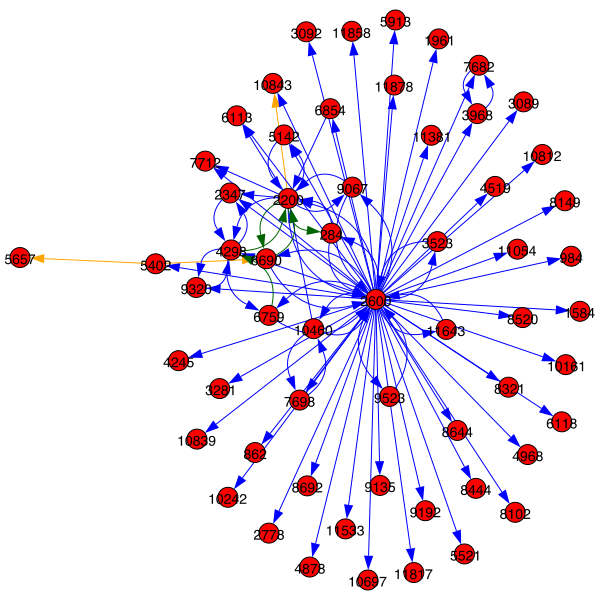

In [0]:
#                   TRY, IF YOU WANT!                 #
 ######################################################
#userNumberTrend(allNetwork)                           #
#edgeNumberTrend(allNetwork)                           #
#tricksterAnalysis(allNetwork)                         #
#communityMemberTrend(communityAffiliation, 0)         #
#communitiesNumberTrend(communityAffiliation)          #
#dissolvedCommunitiesTrend(communityAffiliation)       #
#creationCommunitiesTrend(communityAffiliation)        # 
#retrieveCommunityGraph(allNetwork, 99, 4)             #
#findDiplomats(allNetwork, 5)                          #                     
 ######################################################
# communityGraph = dict()
# communityGraph = retrieveCommunitiesGraph(allNetwork, (5, 5), 3)   
ig.plot(communityGraph[1])
# communityAffiliation = dict()    

# for i in range(0, len(allNetwork)):
#    print(allNetwork[i][1].summary())
#    communityAffiliation[i] = addCommunitiesLabel(allNetwork[i][1], i)
#    print(allNetwork[i][1].summary())
#print("")



In [0]:
# communityStudy(allNetwork, 5)

'''communityGraph = retrieveCommunitiesGraph(allNetwork, (5, 5), 3)    

for day in communityGraph:
    plotToSave = ig.plot(communityGraph[day])
    plotToSave.save(baseURL +'Dash/SingleCommunityStudy/PlotAllDays/day'+str(day+1))

userCommunityNumberTrend(communityGraph)
edgeCommunityNumberTrend(communityGraph)'''
    
# print(communityGraph[1].summary())   
    
    
    

    
    
    
    
    
    
    
    
# communityAffiliation = dict()

'''for i in range(0, len(allNetwork)):
    print(allNetwork[i][3].summary())
    communityAffiliation[i] = addCommunitiesLabel(allNetwork[i][3], i)
    print(allNetwork[i][3].summary())
print("")''''

# print(communityAffiliation[4])

# with open(baseURL+'Dash/CommunitiesActivityTrend.csv', 'w') as csvfile:
#    filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
#    filewriter.writerow(['day', 'CommunityId', 'NumberOfMemberInvolved', 'NumberOfMemberShouldBe', 'NumberOfActive'])
    
#    for day in communityAffiliation:
#        for community in communityAffiliation[day]:
#            filewriter.writerow([int(day+1), community, len(communityAffiliation[day][community][0]),
#                                 communityAffiliation[day][community][1], communityAffiliation[day][community][2]])


# communitiesStory = dict()

# communitiesStory = retrieveCommunitiesGraph(allNetwork, (8, 5, 69, 45), 4)
# findDiplomats(allNetwork, 0) 


# communitiesStory[0].save(baseURL + "Dataset/day0.graphml", format="graphml")
# communitiesStory[1].save(baseURL + "Dataset/day1.graphml", format="graphml")
# communitiesStory[2].save(baseURL + "Dataset/day2.graphml", format="graphml")
# communitiesStory[3].save(baseURL + "Dataset/day3.graphml", format="graphml")

# print(allNetwork[0][0].summary())

# print(allNetwork[0][3].summary())

# print(communityAffiliation[4][140])

# I prefer keep a bin cell rather than cry because i need already written code but deleted....
Of course in the final release this will be delete

# Creation of compact graph (attack, trade and message) and Total Graph and the Alliance Graph (compact and not)
You don't have to run this code if you already have all the graph files in your dataset graphml folder; but **run for another one check**


## Create compact attack graph

In [0]:
# Creation of 30 plain graphs
nGraph = 30
compactAttackGraph = nx.DiGraph()


checkGraph = ig.Graph()
edgesDict = dict()

attackCount = 0

#for each day do
for i in range(0, nGraph):
    
    #Create a new plain graph and read the multigraph for that day
    attackGraph = nx.MultiDiGraph()
    compactAttackGraph = nx.DiGraph()
    checkGraph = ig.Graph(directed = True)
    attackGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Attacks-Network-Graphml/attacks-timestamped-2009-12-"+str(i+1)+".graphml")
    checkGraph = checkGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Multi/Attacks-Network-Graphml/attacks-timestamped-2009-12-"+str(i+1)+".graphml")
    
    #initialize the counters
    attackCount = 0
    sumOfVertex = 0
    nStep = 0
    zeroOutDegreeCont = 0
    edgesDict = dict()
    
    
    dayInDistribution = dict()
    dayOutDistribution = dict()
    
    finalDayDistribution = dict()
    
    totalInEdges = 0
    totalOutEdges = 0
    nNodes = 0
    n100 = 0
    n1_10 = 0

    print("DAY: ", (i+1))
    print("START GRAPH")
    print(nx.info(attackGraph))
    print("")
    
    with open(baseURL+"Dash/DiameterValue/AttackGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'Diameter'])
        
        filewriter.writerow([i + 1, checkGraph.diameter(directed=True)])
    
    for vertex in checkGraph.vs():
        totalInEdges += vertex.indegree()
        if vertex.indegree() > 100:
            n100 += 1
        if vertex.indegree() >= 1 and vertex.indegree() <= 10:
            n1_10 += 1
            
        if vertex.indegree() in dayInDistribution:
            dayInDistribution[vertex.indegree()] += 1
            nNodes += 1
        else:
            dayInDistribution[vertex.indegree()] = 1
            nNodes += 1
            
        if vertex.outdegree() in dayOutDistribution:
            dayOutDistribution[vertex.outdegree()] += 1
        else:
            dayOutDistribution[vertex.outdegree()] = 1
    
    print("INDEGREE DISTRIBUTION")
    finalDayDistribution[0] = 0
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
     
    print("NODES: ", nNodes)
    print("EDGES: ", totalInEdges)
    print("MAJOR THAN 100: ", n100)
    print("BETWEEN 1-10: ", n1_10)
    
    startBound = 1
    endBound = 10
    
    finalDayDistribution[0] = dayInDistribution[0]
    
    while endBound <= 100:
        for key in dayInDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayInDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayInDistribution[key]
        endBound += 10
        startBound += 10
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)
    print("")
    
    with open(baseURL+"Dash/InDegreeDistribution/GraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'Type', 'Range', 'Value'])
        for key in finalDayDistribution:
            filewriter.writerow([i + 1, 'Attack', key, finalDayDistribution[key]/len(checkGraph.vs)])
        
    with open(baseURL+"Dash/AverageDegree/AttackGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'AverageDegree'])
        
        filewriter.writerow([i + 1, round(len(checkGraph.es)/len(checkGraph.vs), 3)])
    
    print("OUTDEGREE DISTRIBUTION")
    finalDayDistribution[0] = dayOutDistribution[0]
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
    
    startBound = 1
    endBound = 10
    
    while endBound <= 100:
        for key in dayOutDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayOutDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayOutDistribution[key]
        endBound += 10
        startBound += 10
        
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)

    with open(baseURL+"Dash/OutDegreeDistribution/AttackGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', '0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '>100'])
        
        filewriter.writerow([i + 1, finalDayDistribution[0]/len(checkGraph.vs), finalDayDistribution['1-10']/len(checkGraph.vs), finalDayDistribution['11-20']/len(checkGraph.vs),
                             finalDayDistribution['21-30']/len(checkGraph.vs), finalDayDistribution['31-40']/len(checkGraph.vs), finalDayDistribution['41-50']/len(checkGraph.vs),
                             finalDayDistribution['51-60']/len(checkGraph.vs), finalDayDistribution['61-70']/len(checkGraph.vs), finalDayDistribution['71-80']/len(checkGraph.vs),
                             finalDayDistribution['81-90']/len(checkGraph.vs), finalDayDistribution['91-100']/len(checkGraph.vs), finalDayDistribution['>100']/len(checkGraph.vs)])
        
        
    
    print("")
        
    
    #for each edge of the multigraph
    for itr in list(attackGraph.edges(None, True, True)):
        # print(itr)
        #create a tmp dictionary to count the numbers of messages and trades between each couple of nodes
        if itr[0] in edgesDict:
            if itr[1] in edgesDict[itr[0]]:
                edgesDict[itr[0]][itr[1]] += 1
                attackCount += 1
            else:
                edgesDict[itr[0]][itr[1]] = 1
                attackCount += 1
        else:
            edgesDict[itr[0]] = {}
            edgesDict[itr[0]][itr[1]] = 1
            attackCount += 1

    #For each edges saved in the dictionary add it to the plain graph
    for fromVertex in edgesDict:
        for toVertex in edgesDict[fromVertex]:
            nStep += 1
            compactAttackGraph.add_edge(int(fromVertex), int(toVertex), Weight = edgesDict[fromVertex][toVertex])
            '''print("FROM VERTEX: ", fromVertex)
            print("VALUE: ", edgesDict[fromVertex])
            print("TO VERTEX: ", toVertex)
            print("VALUE: ", edgesDict[fromVertex][toVertex])
            print("SUM: ", sum(edgesDict[fromVertex][toVertex]))'''
            sumOfVertex += edgesDict[fromVertex][toVertex]

        
    print("FROM VERTICES NUMBER IN DICTIONARY: ", len(edgesDict))
    print("START GRAPH ALL VERTICES: ", len(attackGraph))

    #Count number of inactive nodes
    for vertex in checkGraph.vs:
        if vertex.outdegree() == 0:
            zeroOutDegreeCont += 1
    print("VERTICES WITH OUTDEGREE 0:", zeroOutDegreeCont)
    print("")

    print("END GRAPH")
    print(nx.info(compactAttackGraph))
    print("")
    # for itr in realAllianceGraph.edges_iter(None, True, True):
        # print(itr)
    print("SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER): ", sumOfVertex)
    print("NUMBER OF STEP (END GRAPH EDGES NUMBER): ", nStep)
    print("NUMBER OF ATTACK EDGES MET: ", attackCount)
    nx.write_graphml(compactAttackGraph, baseURL + "Dataset/Graphml-File/Compact/AttackGraph/cAttack-2009-12-"+str(i+1)+".graphml")
    print('----------------------------------------------------------------------')

    

DAY:  1
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 2807
Number of edges: 32997
Average in degree:  11.7553
Average out degree:  11.7553

INDEGREE DISTRIBUTION
NODES:  2807
EDGES:  32997
MAJOR THAN 100:  13
BETWEEN 1-10:  1096
0 747
1-10 1096
11-20 408
21-30 247
31-40 120
41-50 79
51-60 48
61-70 26
71-80 11
81-90 7
91-100 5
>100 13.0
2807
1.0

OUTDEGREE DISTRIBUTION
0 1869
1-10 625
11-20 128
21-30 48
31-40 23
41-50 23
51-60 13
61-70 7
71-80 5
81-90 7
91-100 4
>100 55.0
2807
1.0

FROM VERTICES NUMBER IN DICTIONARY:  938
START GRAPH ALL VERTICES:  2807
VERTICES WITH OUTDEGREE 0: 1869

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 2807
Number of edges: 7476
Average in degree:   2.6633
Average out degree:   2.6633

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  32997
NUMBER OF STEP (END GRAPH EDGES NUMBER):  7476
NUMBER OF ATTACK EDGES MET:  32997
----------------------------------------------------------------------
DAY:  2
START GRAPH
Name: 
Type: MultiDiGraph
Nu

DAY:  10
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 2145
Number of edges: 22778
Average in degree:  10.6191
Average out degree:  10.6191

INDEGREE DISTRIBUTION
NODES:  2145
EDGES:  22778
MAJOR THAN 100:  10
BETWEEN 1-10:  794
0 659
1-10 794
11-20 316
21-30 173
31-40 94
41-50 48
51-60 17
61-70 15
71-80 9
81-90 6
91-100 4
>100 10.0
2145
0.9999999999999999

OUTDEGREE DISTRIBUTION
0 1321
1-10 556
11-20 108
21-30 53
31-40 26
41-50 13
51-60 9
61-70 6
71-80 2
81-90 8
91-100 3
>100 40.0
2145
0.9999999999999998

FROM VERTICES NUMBER IN DICTIONARY:  824
START GRAPH ALL VERTICES:  2145
VERTICES WITH OUTDEGREE 0: 1321

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 2145
Number of edges: 5125
Average in degree:   2.3893
Average out degree:   2.3893

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  22778
NUMBER OF STEP (END GRAPH EDGES NUMBER):  5125
NUMBER OF ATTACK EDGES MET:  22778
----------------------------------------------------------------------
DAY:  11
START GRAPH
N

DAY:  19
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1805
Number of edges: 18820
Average in degree:  10.4266
Average out degree:  10.4266

INDEGREE DISTRIBUTION
NODES:  1805
EDGES:  18820
MAJOR THAN 100:  7
BETWEEN 1-10:  694
0 529
1-10 694
11-20 260
21-30 150
31-40 78
41-50 48
51-60 19
61-70 12
71-80 2
81-90 3
91-100 3
>100 7.0
1805
1.0

OUTDEGREE DISTRIBUTION
0 1153
1-10 439
11-20 82
21-30 29
31-40 18
41-50 23
51-60 14
61-70 5
71-80 2
81-90 3
91-100 5
>100 32.0
1805
0.9999999999999999

FROM VERTICES NUMBER IN DICTIONARY:  652
START GRAPH ALL VERTICES:  1805
VERTICES WITH OUTDEGREE 0: 1153

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1805
Number of edges: 4286
Average in degree:   2.3745
Average out degree:   2.3745

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  18820
NUMBER OF STEP (END GRAPH EDGES NUMBER):  4286
NUMBER OF ATTACK EDGES MET:  18820
----------------------------------------------------------------------
DAY:  20
START GRAPH
Name: 
Type: Multi

DAY:  28
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1633
Number of edges: 17057
Average in degree:  10.4452
Average out degree:  10.4452

INDEGREE DISTRIBUTION
NODES:  1633
EDGES:  17057
MAJOR THAN 100:  6
BETWEEN 1-10:  636
0 500
1-10 636
11-20 223
21-30 99
31-40 76
41-50 45
51-60 20
61-70 13
71-80 6
81-90 6
91-100 3
>100 6.0
1633
1.0

OUTDEGREE DISTRIBUTION
0 1007
1-10 431
11-20 71
21-30 29
31-40 16
41-50 15
51-60 10
61-70 16
71-80 8
81-90 1
91-100 1
>100 28.0
1633
1.0

FROM VERTICES NUMBER IN DICTIONARY:  626
START GRAPH ALL VERTICES:  1633
VERTICES WITH OUTDEGREE 0: 1007

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1633
Number of edges: 3905
Average in degree:   2.3913
Average out degree:   2.3913

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  17057
NUMBER OF STEP (END GRAPH EDGES NUMBER):  3905
NUMBER OF ATTACK EDGES MET:  17057
----------------------------------------------------------------------
DAY:  29
START GRAPH
Name: 
Type: MultiDiGraph
Number 

## Create compact trade graph

In [0]:
# Creation of 30 plain graphs
nGraph = 30
compactTradeGraph = nx.DiGraph()


checkGraph = ig.Graph()
edgesDict = dict()

cont = 0
tradeCount = 0

#for each day do
for i in range(0, nGraph):
    
    #Create a new plain graph and read the multigraph for that day
    tradeGraph = nx.MultiDiGraph()
    compactTradeGraph = nx.DiGraph()
    checkGraph = ig.Graph()
    tradeGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Trades-Network-Graphml/trades-timestamped-2009-12-"+str(i+1)+".graphml")
    checkGraph = checkGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Multi/Trades-Network-Graphml/trades-timestamped-2009-12-"+str(i+1)+".graphml")
    
    #initialize the counters
    tradeCount = 0
    sumOfVertex = 0
    nStep = 0
    zeroOutDegreeCont = 0
    edgesDict = dict()
    
    dayInDistribution = dict()
    dayOutDistribution = dict()
    
    finalDayDistribution = dict()
    
    totalInEdges = 0
    totalOutEdges = 0
    nNodes = 0
    n100 = 0
    n1_10 = 0
    
    with open(baseURL+"Dash/DiameterValue/TradeGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'Diameter'])
        
        filewriter.writerow([i + 1, checkGraph.diameter(directed=True)])
    
    for vertex in checkGraph.vs():
        totalInEdges += vertex.indegree()
        if vertex.indegree() > 100:
            n100 += 1
        if vertex.indegree() >= 1 and vertex.indegree() <= 10:
            n1_10 += 1
            
        if vertex.indegree() in dayInDistribution:
            dayInDistribution[vertex.indegree()] += 1
            nNodes += 1
        else:
            dayInDistribution[vertex.indegree()] = 1
            nNodes += 1
            
        if vertex.outdegree() in dayOutDistribution:
            dayOutDistribution[vertex.outdegree()] += 1
        else:
            dayOutDistribution[vertex.outdegree()] = 1
    
    print("INDEGREE DISTRIBUTION")
    finalDayDistribution[0] = 0
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
     
    print("NODES: ", nNodes)
    print("EDGES: ", totalInEdges)
    print("MAJOR THAN 100: ", n100)
    print("BETWEEN 1-10: ", n1_10)
    
    startBound = 1
    endBound = 10
    
    finalDayDistribution[0] = dayInDistribution[0]
    
    while endBound <= 100:
        for key in dayInDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayInDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayInDistribution[key]
        endBound += 10
        startBound += 10
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)
    print("")
    
    with open(baseURL+"Dash/InDegreeDistribution/GraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for key in finalDayDistribution:
            filewriter.writerow([i + 1, 'Trade', key, finalDayDistribution[key]/len(checkGraph.vs)])
        
    with open(baseURL+"Dash/AverageDegree/TradeGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'AverageDegree'])
        
        filewriter.writerow([i + 1, round(len(checkGraph.es)/len(checkGraph.vs), 3)])
    
    print("OUTDEGREE DISTRIBUTION")
    finalDayDistribution[0] = dayOutDistribution[0]
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
    
    startBound = 1
    endBound = 10
    
    while endBound <= 100:
        for key in dayOutDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayOutDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayOutDistribution[key]
        endBound += 10
        startBound += 10
        
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)

    with open(baseURL+"Dash/OutDegreeDistribution/TradeGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', '0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '>100'])
        
        filewriter.writerow([i + 1, finalDayDistribution[0]/len(checkGraph.vs), finalDayDistribution['1-10']/len(checkGraph.vs), finalDayDistribution['11-20']/len(checkGraph.vs),
                             finalDayDistribution['21-30']/len(checkGraph.vs), finalDayDistribution['31-40']/len(checkGraph.vs), finalDayDistribution['41-50']/len(checkGraph.vs),
                             finalDayDistribution['51-60']/len(checkGraph.vs), finalDayDistribution['61-70']/len(checkGraph.vs), finalDayDistribution['71-80']/len(checkGraph.vs),
                             finalDayDistribution['81-90']/len(checkGraph.vs), finalDayDistribution['91-100']/len(checkGraph.vs), finalDayDistribution['>100']/len(checkGraph.vs)])
    print("")

    print("DAY: ", (i+1))
    print("START GRAPH")
    print(nx.info(tradeGraph))
    print("")
    
    #for each edge of the multigraph
    for itr in list(tradeGraph.edges(None, True, True)):
        # print(itr)
        #create a tmp dictionary to count the numbers of messages and trades between each couple of nodes
        if itr[0] in edgesDict:
            if itr[1] in edgesDict[itr[0]]:
                edgesDict[itr[0]][itr[1]] += 1
                tradeCount += 1
            else:
                edgesDict[itr[0]][itr[1]] = 1
                tradeCount += 1
        else:
            edgesDict[itr[0]] = {}
            edgesDict[itr[0]][itr[1]] = 1
            tradeCount += 1

    
    #For each edges saved in the dictionary add it to the plain graph
    for fromVertex in edgesDict:
        for toVertex in edgesDict[fromVertex]:
            if fromVertex == "2789":
                print(fromVertex)
                cont += edgesDict[fromVertex][toVertex]
            nStep += 1
            compactTradeGraph.add_edge(int(fromVertex), int(toVertex), Weight = edgesDict[fromVertex][toVertex])
            '''print("FROM VERTEX: ", fromVertex)
            print("VALUE: ", edgesDict[fromVertex])
            print("TO VERTEX: ", toVertex)
            print("VALUE: ", edgesDict[fromVertex][toVertex])
            print("SUM: ", sum(edgesDict[fromVertex][toVertex]))'''
            sumOfVertex += edgesDict[fromVertex][toVertex]

        
    print("FROM VERTICES NUMBER IN DICTIONARY: ", len(edgesDict))
    print("START GRAPH ALL VERTICES: ", len(tradeGraph))

    #Count number of inactive nodes
    for vertex in checkGraph.vs:
        if vertex.outdegree() == 0:
            zeroOutDegreeCont += 1
    print("VERTICES WITH OUTDEGREE 0:", zeroOutDegreeCont)
    print("")

    print("END GRAPH")
    print(nx.info(compactTradeGraph))
    print("")
    # for itr in realAllianceGraph.edges_iter(None, True, True):
        # print(itr)
    print("SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER): ", sumOfVertex)
    print("NUMBER OF STEP (END GRAPH EDGES NUMBER): ", nStep)
    print("NUMBER OF TRADE EDGES MET: ", tradeCount)
    nx.write_graphml(compactTradeGraph, baseURL + "Dataset/Graphml-File/Compact/TradeGraph/cTrade-2009-12-"+str(i+1)+".graphml")
    print('----------------------------------------------------------------------')
print(cont)
    

INDEGREE DISTRIBUTION
NODES:  1336
EDGES:  9390
MAJOR THAN 100:  5
BETWEEN 1-10:  873
0 222
1-10 873
11-20 139
21-30 45
31-40 29
41-50 9
51-60 6
61-70 4
71-80 2
81-90 2
91-100 0
>100 5.0
1336
0.9999999999999999

OUTDEGREE DISTRIBUTION
0 127
1-10 962
11-20 155
21-30 45
31-40 22
41-50 8
51-60 5
61-70 4
71-80 1
81-90 3
91-100 1
>100 3.0
1336
0.9999999999999999

DAY:  1
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1336
Number of edges: 9390
Average in degree:   7.0284
Average out degree:   7.0284

2789
FROM VERTICES NUMBER IN DICTIONARY:  1209
START GRAPH ALL VERTICES:  1336
VERTICES WITH OUTDEGREE 0: 127

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1336
Number of edges: 4909
Average in degree:   3.6744
Average out degree:   3.6744

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  9390
NUMBER OF STEP (END GRAPH EDGES NUMBER):  4909
NUMBER OF TRADE EDGES MET:  9390
----------------------------------------------------------------------
INDEGREE DISTRIBUTION
NODES:  13

INDEGREE DISTRIBUTION
NODES:  1248
EDGES:  8921
MAJOR THAN 100:  2
BETWEEN 1-10:  774
0 213
1-10 774
11-20 163
21-30 47
31-40 22
41-50 13
51-60 7
61-70 4
71-80 0
81-90 0
91-100 3
>100 2.0
1248
0.9999999999999999

OUTDEGREE DISTRIBUTION
0 109
1-10 875
11-20 168
21-30 47
31-40 23
41-50 14
51-60 5
61-70 6
71-80 0
81-90 0
91-100 1
>100 0.0
1248
0.9999999999999999

DAY:  10
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1248
Number of edges: 8921
Average in degree:   7.1482
Average out degree:   7.1482

2789
FROM VERTICES NUMBER IN DICTIONARY:  1139
START GRAPH ALL VERTICES:  1248
VERTICES WITH OUTDEGREE 0: 109

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1248
Number of edges: 4769
Average in degree:   3.8213
Average out degree:   3.8213

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  8921
NUMBER OF STEP (END GRAPH EDGES NUMBER):  4769
NUMBER OF TRADE EDGES MET:  8921
----------------------------------------------------------------------
INDEGREE DISTRIBUTION
NODES: 

INDEGREE DISTRIBUTION
NODES:  1099
EDGES:  8624
MAJOR THAN 100:  6
BETWEEN 1-10:  631
0 234
1-10 631
11-20 140
21-30 43
31-40 23
41-50 7
51-60 4
61-70 4
71-80 5
81-90 0
91-100 2
>100 6.0
1099
1.0000000000000002

OUTDEGREE DISTRIBUTION
0 101
1-10 758
11-20 144
21-30 47
31-40 24
41-50 7
51-60 5
61-70 2
71-80 4
81-90 2
91-100 2
>100 3.0
1099
0.9999999999999999

DAY:  19
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1099
Number of edges: 8624
Average in degree:   7.8471
Average out degree:   7.8471

2789
FROM VERTICES NUMBER IN DICTIONARY:  998
START GRAPH ALL VERTICES:  1099
VERTICES WITH OUTDEGREE 0: 101

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1099
Number of edges: 4269
Average in degree:   3.8844
Average out degree:   3.8844

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  8624
NUMBER OF STEP (END GRAPH EDGES NUMBER):  4269
NUMBER OF TRADE EDGES MET:  8624
----------------------------------------------------------------------
INDEGREE DISTRIBUTION
NODES:  10

INDEGREE DISTRIBUTION
NODES:  1017
EDGES:  8665
MAJOR THAN 100:  6
BETWEEN 1-10:  620
0 169
1-10 620
11-20 120
21-30 46
31-40 27
41-50 12
51-60 4
61-70 9
71-80 1
81-90 3
91-100 0
>100 6.0
1017
1.0000000000000002

OUTDEGREE DISTRIBUTION
0 92
1-10 684
11-20 134
21-30 52
31-40 24
41-50 11
51-60 4
61-70 8
71-80 1
81-90 2
91-100 1
>100 4.0
1017
1.0

DAY:  28
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1017
Number of edges: 8665
Average in degree:   8.5202
Average out degree:   8.5202

2789
FROM VERTICES NUMBER IN DICTIONARY:  925
START GRAPH ALL VERTICES:  1017
VERTICES WITH OUTDEGREE 0: 92

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1017
Number of edges: 4057
Average in degree:   3.9892
Average out degree:   3.9892

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  8665
NUMBER OF STEP (END GRAPH EDGES NUMBER):  4057
NUMBER OF TRADE EDGES MET:  8665
----------------------------------------------------------------------
INDEGREE DISTRIBUTION
NODES:  991
EDGES:  8606


## Create compact message graph

In [0]:
# Creation of 30 plain graphs
nGraph = 30
compactMessageGraph = nx.DiGraph()


checkGraph = ig.Graph()
edgesDict = dict()

messageCount = 0

#for each day do
for i in range(0, nGraph):
    
    #Create a new plain graph and read the multigraph for that day
    messageGraph = nx.MultiDiGraph()
    compactMessageGraph = nx.DiGraph()
    checkGraph = ig.Graph()
    messageGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Messages-Network-Graphml/messages-timestamped-2009-12-"+str(i+1)+".graphml")
    checkGraph = checkGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Multi/Messages-Network-Graphml/messages-timestamped-2009-12-"+str(i+1)+".graphml")
    
    #initialize the counters
    messageCount = 0
    sumOfVertex = 0
    nStep = 0
    zeroOutDegreeCont = 0
    edgesDict = dict()

    print("DAY: ", (i+1))
    print("START GRAPH")
    print(nx.info(messageGraph))
    print("")
    
    with open(baseURL+"Dash/DiameterValue/MessageGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'Diameter'])
        
        filewriter.writerow([i + 1, checkGraph.diameter(directed=True)])
    
    dayInDistribution = dict()
    dayOutDistribution = dict()
    
    finalDayDistribution = dict()
    
    totalInEdges = 0
    totalOutEdges = 0
    nNodes = 0
    n100 = 0
    n1_10 = 0
    
    for vertex in checkGraph.vs():
        totalInEdges += vertex.indegree()
        if vertex.indegree() > 100:
            n100 += 1
        if vertex.indegree() >= 1 and vertex.indegree() <= 10:
            n1_10 += 1
            
        if vertex.indegree() in dayInDistribution:
            dayInDistribution[vertex.indegree()] += 1
            nNodes += 1
        else:
            dayInDistribution[vertex.indegree()] = 1
            nNodes += 1
            
        if vertex.outdegree() in dayOutDistribution:
            dayOutDistribution[vertex.outdegree()] += 1
        else:
            dayOutDistribution[vertex.outdegree()] = 1
    
    print("INDEGREE DISTRIBUTION")
    finalDayDistribution[0] = 0
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
     
    print("NODES: ", nNodes)
    print("EDGES: ", totalInEdges)
    print("MAJOR THAN 100: ", n100)
    print("BETWEEN 1-10: ", n1_10)
    
    startBound = 1
    endBound = 10
    
    finalDayDistribution[0] = dayInDistribution[0]
    
    while endBound <= 100:
        for key in dayInDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayInDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayInDistribution[key]
        endBound += 10
        startBound += 10
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)
    print("")
    
    with open(baseURL+"Dash/InDegreeDistribution/GraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
        for key in finalDayDistribution:
            filewriter.writerow([i + 1, 'Message', key, finalDayDistribution[key]/len(checkGraph.vs)])
        
    with open(baseURL+"Dash/AverageDegree/MessageGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', 'AverageDegree'])
        
        filewriter.writerow([i + 1, round(len(checkGraph.es)/len(checkGraph.vs), 3)])
    
    print("OUTDEGREE DISTRIBUTION")
    finalDayDistribution[0] = dayOutDistribution[0]
    finalDayDistribution['1-10'] = 0
    finalDayDistribution['11-20'] = 0
    finalDayDistribution['21-30'] = 0
    finalDayDistribution['31-40'] = 0
    finalDayDistribution['41-50'] = 0
    finalDayDistribution['51-60'] = 0
    finalDayDistribution['61-70'] = 0
    finalDayDistribution['71-80'] = 0
    finalDayDistribution['81-90'] = 0
    finalDayDistribution['91-100'] = 0
    finalDayDistribution['>100'] = 0  
    
    startBound = 1
    endBound = 10
    
    while endBound <= 100:
        for key in dayOutDistribution:
            if key > 100:
                finalDayDistribution[">100"] += dayOutDistribution[key]
            elif key >= startBound and key <= endBound:
                    finalDayDistribution[""+str(startBound)+"-"+str(endBound)+""] += dayOutDistribution[key]
        endBound += 10
        startBound += 10
        
        
    finalDayDistribution[">100"] = finalDayDistribution[">100"]/10
    
    nodesCont = 0
    totalDistribution = 0
    for key in finalDayDistribution:
        nodesCont += int(finalDayDistribution[key])
        print(key, finalDayDistribution[key])
        totalDistribution += finalDayDistribution[key]/len(checkGraph.vs)
    
    print(nodesCont)
    print(totalDistribution)

    with open(baseURL+"Dash/OutDegreeDistribution/MessageGraphData.csv", 'a+') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        if i == 0:
            filewriter.writerow(['Day', '0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '>100'])
        
        filewriter.writerow([i + 1, finalDayDistribution[0]/len(checkGraph.vs), finalDayDistribution['1-10']/len(checkGraph.vs), finalDayDistribution['11-20']/len(checkGraph.vs),
                             finalDayDistribution['21-30']/len(checkGraph.vs), finalDayDistribution['31-40']/len(checkGraph.vs), finalDayDistribution['41-50']/len(checkGraph.vs),
                             finalDayDistribution['51-60']/len(checkGraph.vs), finalDayDistribution['61-70']/len(checkGraph.vs), finalDayDistribution['71-80']/len(checkGraph.vs),
                             finalDayDistribution['81-90']/len(checkGraph.vs), finalDayDistribution['91-100']/len(checkGraph.vs), finalDayDistribution['>100']/len(checkGraph.vs)])
    print("")
    #for each edge of the multigraph
    for itr in list(messageGraph.edges(None, True, True)):
        # print(itr)
        #create a tmp dictionary to count the numbers of messages and trades between each couple of nodes
        if itr[0] in edgesDict:
            if itr[1] in edgesDict[itr[0]]:
                edgesDict[itr[0]][itr[1]] += 1
                messageCount += 1
            else:
                edgesDict[itr[0]][itr[1]] = 1
                messageCount += 1
        else:
            edgesDict[itr[0]] = {}
            edgesDict[itr[0]][itr[1]] = 1
            messageCount += 1

    #For each edges saved in the dictionary add it to the plain graph
    for fromVertex in edgesDict:
        for toVertex in edgesDict[fromVertex]:
            nStep += 1
            compactMessageGraph.add_edge(int(fromVertex), int(toVertex), Weight = edgesDict[fromVertex][toVertex])
            '''print("FROM VERTEX: ", fromVertex)
            print("VALUE: ", edgesDict[fromVertex])
            print("TO VERTEX: ", toVertex)
            print("VALUE: ", edgesDict[fromVertex][toVertex])
            print("SUM: ", sum(edgesDict[fromVertex][toVertex]))'''
            sumOfVertex += edgesDict[fromVertex][toVertex]

        
    print("FROM VERTICES NUMBER IN DICTIONARY: ", len(edgesDict))
    print("START GRAPH ALL VERTICES: ", len(messageGraph))

    #Count number of inactive nodes
    for vertex in checkGraph.vs:
        if vertex.outdegree() == 0:
            zeroOutDegreeCont += 1
    print("VERTICES WITH OUTDEGREE 0:", zeroOutDegreeCont)
    print("")

    print("END GRAPH")
    print(nx.info(compactMessageGraph))
    print("")
    # for itr in realAllianceGraph.edges_iter(None, True, True):
        # print(itr)
    print("SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER): ", sumOfVertex)
    print("NUMBER OF STEP (END GRAPH EDGES NUMBER): ", nStep)
    print("NUMBER OF MESSAGE EDGES MET: ", messageCount)
    nx.write_graphml(compactMessageGraph, baseURL + "Dataset/Graphml-File/Compact/MessageGraph/cMessage-2009-12-"+str(i+1)+".graphml")
    print('----------------------------------------------------------------------')

    

DAY:  1
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1963
Number of edges: 16346
Average in degree:   8.3271
Average out degree:   8.3271

INDEGREE DISTRIBUTION
NODES:  1963
EDGES:  16346
MAJOR THAN 100:  3
BETWEEN 1-10:  1438
0 56
1-10 1438
11-20 325
21-30 76
31-40 30
41-50 12
51-60 6
61-70 7
71-80 5
81-90 2
91-100 3
>100 3.0
1963
1.0

OUTDEGREE DISTRIBUTION
0 795
1-10 912
11-20 116
21-30 46
31-40 14
41-50 9
51-60 7
61-70 11
71-80 3
81-90 10
91-100 2
>100 38.0
1963
1.0000000000000002

FROM VERTICES NUMBER IN DICTIONARY:  1168
START GRAPH ALL VERTICES:  1963
VERTICES WITH OUTDEGREE 0: 795

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1963
Number of edges: 6485
Average in degree:   3.3036
Average out degree:   3.3036

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  16346
NUMBER OF STEP (END GRAPH EDGES NUMBER):  6485
NUMBER OF MESSAGE EDGES MET:  16346
----------------------------------------------------------------------
DAY:  2
START GRAPH
Name: 
Type: MultiDiG

DAY:  10
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1743
Number of edges: 14643
Average in degree:   8.4010
Average out degree:   8.4010

INDEGREE DISTRIBUTION
NODES:  1743
EDGES:  14643
MAJOR THAN 100:  5
BETWEEN 1-10:  1280
0 59
1-10 1280
11-20 247
21-30 82
31-40 30
41-50 20
51-60 7
61-70 7
71-80 4
81-90 1
91-100 1
>100 5.0
1743
1.0000000000000002

OUTDEGREE DISTRIBUTION
0 670
1-10 847
11-20 112
21-30 28
31-40 16
41-50 8
51-60 12
61-70 10
71-80 6
81-90 2
91-100 1
>100 31.0
1743
0.9999999999999999

FROM VERTICES NUMBER IN DICTIONARY:  1073
START GRAPH ALL VERTICES:  1743
VERTICES WITH OUTDEGREE 0: 670

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1743
Number of edges: 5326
Average in degree:   3.0557
Average out degree:   3.0557

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  14643
NUMBER OF STEP (END GRAPH EDGES NUMBER):  5326
NUMBER OF MESSAGE EDGES MET:  14643
----------------------------------------------------------------------
DAY:  11
START GRAPH
Name

DAY:  19
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1658
Number of edges: 14883
Average in degree:   8.9765
Average out degree:   8.9765

INDEGREE DISTRIBUTION
NODES:  1658
EDGES:  14883
MAJOR THAN 100:  4
BETWEEN 1-10:  1159
0 40
1-10 1159
11-20 307
21-30 77
31-40 42
41-50 8
51-60 10
61-70 6
71-80 2
81-90 3
91-100 0
>100 4.0
1658
0.9999999999999998

OUTDEGREE DISTRIBUTION
0 791
1-10 670
11-20 81
21-30 26
31-40 17
41-50 7
51-60 13
61-70 13
71-80 7
81-90 3
91-100 1
>100 29.0
1658
1.0

FROM VERTICES NUMBER IN DICTIONARY:  867
START GRAPH ALL VERTICES:  1658
VERTICES WITH OUTDEGREE 0: 791

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1658
Number of edges: 5091
Average in degree:   3.0706
Average out degree:   3.0706

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  14883
NUMBER OF STEP (END GRAPH EDGES NUMBER):  5091
NUMBER OF MESSAGE EDGES MET:  14883
----------------------------------------------------------------------
DAY:  20
START GRAPH
Name: 
Type: MultiDiG

DAY:  28
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 1512
Number of edges: 8869
Average in degree:   5.8657
Average out degree:   5.8657

INDEGREE DISTRIBUTION
NODES:  1512
EDGES:  8869
MAJOR THAN 100:  1
BETWEEN 1-10:  1238
0 55
1-10 1238
11-20 163
21-30 30
31-40 15
41-50 6
51-60 2
61-70 2
71-80 0
81-90 0
91-100 0
>100 1.0
1512
1.0

OUTDEGREE DISTRIBUTION
0 731
1-10 650
11-20 57
21-30 18
31-40 10
41-50 8
51-60 9
61-70 6
71-80 3
81-90 3
91-100 3
>100 14.0
1512
1.0

FROM VERTICES NUMBER IN DICTIONARY:  781
START GRAPH ALL VERTICES:  1512
VERTICES WITH OUTDEGREE 0: 731

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1512
Number of edges: 3669
Average in degree:   2.4266
Average out degree:   2.4266

SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  8869
NUMBER OF STEP (END GRAPH EDGES NUMBER):  3669
NUMBER OF MESSAGE EDGES MET:  8869
----------------------------------------------------------------------
DAY:  29
START GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 

## Create Total and Alliance Graph

In [0]:
# create a multigraph for all nets type
messageGraph = nx.MultiDiGraph()
tradeGraph = nx.MultiDiGraph()
attackGraph = nx.MultiDiGraph()

attackSelf = 0
messageSelf = 0

# number of graph (30 in our case)
nGraph = 30

# for every day is needed create total and alliance graph
for i in range(0, nGraph):
    print("Graph number: ", (i + 1))
    
    # for every day is needed reinitialize the "real" graphs (graph with edge label)
    realAttack = nx.MultiDiGraph()
    realMessage = nx.MultiDiGraph()
    realTrade = nx.MultiDiGraph()
    
    attackSelf = 0
    messageSelf = 0
    
    # for every day is needed reinitialize the alliance graph and total graph
    allianceGraph = nx.MultiDiGraph()
    totalGraph = nx.MultiDiGraph()
    
    # read from Dataset/Graphml-File the correct file based on type and day
    attackGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Attacks-Network-Graphml/attacks-timestamped-2009-12-"+str(i+1)+".graphml")
    messageGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Messages-Network-Graphml/messages-timestamped-2009-12-"+str(i+1)+".graphml")
    tradeGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Trades-Network-Graphml/trades-timestamped-2009-12-"+str(i+1)+".graphml")
    
    # copy xxxxGraph in realxxxx adding label to edges; keep attentio about key, it must be unique (we use old key + 
    # letter for define edge tipology) 
    for itr in list(messageGraph.edges(None, True, True)):
    #for itr in messageGraph.edges_iter(None, True, True):
        if int(itr[0]) != int(itr[1]):
            realMessage.add_edge(int(itr[0]),int(itr[1]), key=str(itr[2])+"m", Label= "Message", time = itr[3]['edgetime'])
        else:
            messageSelf += 1
    
    #for itr in tradeGraph.edges_iter(None, True, True):
    for itr in list(tradeGraph.edges(None, True, True)):
        realTrade.add_edge(int(itr[0]),int(itr[1]), key=str(itr[2])+"t", Label = "Trade", time = itr[3]['edgetime'])

    #for itr in attackGraph.edges_iter(None, True, True):
    for itr in list(attackGraph.edges(None, True, True)):
        if int(itr[0]) != int(itr[1]):
            realAttack.add_edge(int(itr[0]),int(itr[1]), key=str(itr[2])+"a", Label= "Attack", time = itr[3]['edgetime'])
        else:
            attackSelf += 1
    
    # compose (a union) in one graph the needed graphs 
    allianceGraph = nx.compose(realMessage, realTrade)
    totalGraph = nx.compose(allianceGraph, realAttack)
    # save total graph and alliance graph in the correct file
    nx.write_graphml(totalGraph, baseURL + "Dataset/Graphml-File/Multi/Total-Network-Graphml/Total-2009-12-"+str(i+1)+".graphml")
    nx.write_graphml(allianceGraph, baseURL + "Dataset/Graphml-File/Multi/Alliance-Network-Graphml/Alliance-2009-12-"+str(i+1)+".graphml")

    # print for check, i checked that sum of graphs is the equal to alliance graph and total graph (according to the case)
    # but i think is a better that YOU MAKE THE SAME; ONE MORE CONTROL IS BETTER!
    print("ATTACK GRAPH: ", nx.info(attackGraph))
    print("NO SENSE SELF ATTACK EDGE: ", attackSelf)
    print("MESSAGE GRAPH: ", nx.info(messageGraph))
    print("NO SENSE SELF MESSAGE EDGE: ", messageSelf)
    print("TRADE GRAPH: ", nx.info(tradeGraph))
    print("ALLIANCE GRAPH: ", nx.info(allianceGraph))
    print("TOTAL GRAPH: ", nx.info(totalGraph))
    print("") 

Graph number:  1
ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 2807
Number of edges: 32997
Average in degree:  11.7553
Average out degree:  11.7553
NO SENSE SELF ATTACK EDGE:  0
MESSAGE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1963
Number of edges: 16346
Average in degree:   8.3271
Average out degree:   8.3271
NO SENSE SELF MESSAGE EDGE:  515
TRADE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1336
Number of edges: 9390
Average in degree:   7.0284
Average out degree:   7.0284
ALLIANCE GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2218
Number of edges: 25221
Average in degree:  11.3711
Average out degree:  11.3711
TOTAL GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 3757
Number of edges: 58218
Average in degree:  15.4959
Average out degree:  15.4959

Graph number:  2
ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 2802
Number of edges: 32782
Average in degree:  11.6995
Average out degree:  11.6995
NO SENSE SELF ATTA

ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 2156
Number of edges: 22162
Average in degree:  10.2792
Average out degree:  10.2792
NO SENSE SELF ATTACK EDGE:  0
MESSAGE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1811
Number of edges: 12486
Average in degree:   6.8945
Average out degree:   6.8945
NO SENSE SELF MESSAGE EDGE:  456
TRADE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1205
Number of edges: 9008
Average in degree:   7.4755
Average out degree:   7.4755
ALLIANCE GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2012
Number of edges: 21038
Average in degree:  10.4563
Average out degree:  10.4563
TOTAL GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 3011
Number of edges: 43200
Average in degree:  14.3474
Average out degree:  14.3474

Graph number:  12
ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 2082
Number of edges: 21628
Average in degree:  10.3881
Average out degree:  10.3881
NO SENSE SELF ATTACK EDGE:  0
MESS

ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1828
Number of edges: 18771
Average in degree:  10.2686
Average out degree:  10.2686
NO SENSE SELF ATTACK EDGE:  0
MESSAGE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1572
Number of edges: 11405
Average in degree:   7.2551
Average out degree:   7.2551
NO SENSE SELF MESSAGE EDGE:  295
TRADE GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1010
Number of edges: 8443
Average in degree:   8.3594
Average out degree:   8.3594
ALLIANCE GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 1735
Number of edges: 19553
Average in degree:  11.2697
Average out degree:  11.2697
TOTAL GRAPH:  Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2658
Number of edges: 38324
Average in degree:  14.4184
Average out degree:  14.4184

Graph number:  22
ATTACK GRAPH:  Name: 
Type: MultiDiGraph
Number of nodes: 1775
Number of edges: 16970
Average in degree:   9.5606
Average out degree:   9.5606
NO SENSE SELF ATTACK EDGE:  0
MESS

## Transformation of the Alliance graph to compact plain graph with weighted edges

---

Don't run this code if you already have the plain graph in your dataset folder

In [0]:
#Creation of 30 plain graphs
nGraph = 30
realAllianceGraph = nx.DiGraph()


checkGraph = ig.Graph()
edgesDict = dict()

tradeCount = 0
messageCount = 0
cont = 0

#for each day do
for i in range(0, nGraph):
    
    #Create a new plain graph and read the multigraph for that day
    allianceGraph = nx.MultiDiGraph()
    realAllianceGraph = nx.DiGraph()
    checkGraph = ig.Graph()
    allianceGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Alliance-Network-Graphml/Alliance-2009-12-"+str(i+1)+".graphml")
    checkGraph = checkGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Multi/Alliance-Network-Graphml/Alliance-2009-12-"+str(i+1)+".graphml")
    
    #initialize the counters
    tradeCount = 0
    messageCount = 0
    sumOfVertex = 0
    nStep = 0
    zeroOutDegreeCont = 0
    edgesDict = dict()

    print("DAY: ", (i+1))
    print("START GRAPH")
    print(nx.info(allianceGraph))
    print("")
    
    #for each edge of the multigraph
    for itr in list(allianceGraph.edges(None, True, True)):
        if itr[0] == '7855':
            cont += 1
        # print(itr)
        #create a tmp dictionary to count the numbers of messages and trades between each couple of nodes
        if itr[0] in edgesDict:
            if itr[1] in edgesDict[itr[0]]:
                if itr[3]['Label'] == 'Message':
                    edgesDict[itr[0]][itr[1]][0] += 1
                    messageCount += 1
                elif itr[3]['Label'] == 'Trade':
                    edgesDict[itr[0]][itr[1]][1] += 1
                    tradeCount += 1
            else:
                
                if itr[3]['Label'] == 'Message':
                    edgesDict[itr[0]][itr[1]] = [1, 0]
                    messageCount += 1
                elif itr[3]['Label'] == 'Trade':
                    edgesDict[itr[0]][itr[1]] = [0, 1]
                    tradeCount += 1
        else:
            edgesDict[itr[0]] = {}
            
            if itr[3]['Label'] == 'Message':
                edgesDict[itr[0]][itr[1]] = [1, 0]
                messageCount += 1
            elif itr[3]['Label'] == 'Trade':
                edgesDict[itr[0]][itr[1]] = [0, 1]
                tradeCount += 1

    #For each edges saved in the dictionary add it to the plain graph
    for fromVertex in edgesDict:
        for toVertex in edgesDict[fromVertex]:
            nStep += 1
            realAllianceGraph.add_edge(int(fromVertex), int(toVertex), MWeight = edgesDict[fromVertex][toVertex][0], TWeight = edgesDict[fromVertex][toVertex][1])
            '''print("FROM VERTEX: ", fromVertex)
            print("VALUE: ", edgesDict[fromVertex])
            print("TO VERTEX: ", toVertex)
            print("VALUE: ", edgesDict[fromVertex][toVertex])
            print("SUM: ", sum(edgesDict[fromVertex][toVertex]))'''
            sumOfVertex += sum(edgesDict[fromVertex][toVertex])

        
    print("FROM VERTICES NUMBER IN DICTIONARY: ", len(edgesDict))
    print("START GRAPH ALL VERTICES: ", len(allianceGraph))

    #Count number of inactive nodes
    for vertex in checkGraph.vs:
        if vertex.outdegree() == 0:
            zeroOutDegreeCont += 1
    print("VERTICES WITH OUTDEGREE 0:", zeroOutDegreeCont)
    print("")

    print("END GRAPH")
    print(nx.info(realAllianceGraph))
    print("")
    # for itr in realAllianceGraph.edges_iter(None, True, True):
        # print(itr)
    print("NUMBER OF STEP (END GRAPH EDGES NUMBER): ", nStep)
    print("NUMBER OF TRADE EDGES MET: ", tradeCount)
    print("NUMBER OF MESSAGE EDGES MET: ", messageCount)
    nx.write_graphml(realAllianceGraph, baseURL + "Dataset/Graphml-File/Compact/AllianceGraph/cAlliance-2009-12-"+str(i+1)+".graphml")
    print('----------------------------------------------------------------------')

    print(cont)
    

DAY:  1
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2218
Number of edges: 25221
Average in degree:  11.3711
Average out degree:  11.3711

FROM VERTICES NUMBER IN DICTIONARY:  1707
START GRAPH ALL VERTICES:  2218
VERTICES WITH OUTDEGREE 0: 511

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 2218
Number of edges: 11077
Average in degree:   4.9941
Average out degree:   4.9941

NUMBER OF STEP (END GRAPH EDGES NUMBER):  11077
NUMBER OF TRADE EDGES MET:  9390
NUMBER OF MESSAGE EDGES MET:  15831
----------------------------------------------------------------------
2
DAY:  2
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2311
Number of edges: 23310
Average in degree:  10.0865
Average out degree:  10.0865

FROM VERTICES NUMBER IN DICTIONARY:  1659
START GRAPH ALL VERTICES:  2311
VERTICES WITH OUTDEGREE 0: 652

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 2311
Number of edges: 10448
Average in degree:   4.5210
Average out degree:   4.5210

NUMBER

----------------------------------------------------------------------
7
DAY:  15
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 1948
Number of edges: 21580
Average in degree:  11.0780
Average out degree:  11.0780

FROM VERTICES NUMBER IN DICTIONARY:  1439
START GRAPH ALL VERTICES:  1948
VERTICES WITH OUTDEGREE 0: 509

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1948
Number of edges: 9746
Average in degree:   5.0031
Average out degree:   5.0031

NUMBER OF STEP (END GRAPH EDGES NUMBER):  9746
NUMBER OF TRADE EDGES MET:  10175
NUMBER OF MESSAGE EDGES MET:  11405
----------------------------------------------------------------------
8
DAY:  16
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 1925
Number of edges: 23046
Average in degree:  11.9719
Average out degree:  11.9719

FROM VERTICES NUMBER IN DICTIONARY:  1385
START GRAPH ALL VERTICES:  1925
VERTICES WITH OUTDEGREE 0: 540

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1925
Number of edg

----------------------------------------------------------------------
22
DAY:  29
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 1595
Number of edges: 15994
Average in degree:  10.0276
Average out degree:  10.0276

FROM VERTICES NUMBER IN DICTIONARY:  1192
START GRAPH ALL VERTICES:  1595
VERTICES WITH OUTDEGREE 0: 403

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1595
Number of edges: 7064
Average in degree:   4.4288
Average out degree:   4.4288

NUMBER OF STEP (END GRAPH EDGES NUMBER):  7064
NUMBER OF TRADE EDGES MET:  8606
NUMBER OF MESSAGE EDGES MET:  7388
----------------------------------------------------------------------
22
DAY:  30
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 1670
Number of edges: 16735
Average in degree:  10.0210
Average out degree:  10.0210

FROM VERTICES NUMBER IN DICTIONARY:  1155
START GRAPH ALL VERTICES:  1670
VERTICES WITH OUTDEGREE 0: 515

END GRAPH
Name: 
Type: DiGraph
Number of nodes: 1670
Number of edg

## Transformation of the total multigraph to a multigraph with weighted edges for each type of interaction

---

Don't run this code if you already have the plain graph in your dataset folder

In [0]:

nGraph = 30
compactAllGraph = nx.MultiDiGraph()


checkGraph = ig.Graph()
edgesDict = dict()

tradeCount = 0
messageCount = 0
attackCount = 0
finalCheck = 0
cont = 0

#for each day 
for i in range(0, nGraph):
    
    #create new plaingraphs 
    allGraph = nx.MultiDiGraph()
    compactAllGraph = nx.MultiDiGraph()
    checkGraph = ig.Graph()
    allGraph = nx.read_graphml(baseURL + "Dataset/Graphml-File/Multi/Total-Network-Graphml/Total-2009-12-"+str(i+1)+".graphml")
    checkGraph = checkGraph.Read_GraphML(baseURL + "Dataset/Graphml-File/Multi/Total-Network-Graphml/Total-2009-12-"+str(i+1)+".graphml")
    
    #initialize counters
    tradeCount = 0
    messageCount = 0
    attackCount = 0
    sumOfVertex = 0
    nStep = 0
    zeroOutDegreeCont = 0
    finalCheck = 0
    edgesDict = dict()

    print("DAY: ", (i+1))
    print("START GRAPH")
    print(nx.info(allGraph))
    print("")

    #create a tmp dictionary to count the numbers of messages, trades and attacks between each couple of nodes 
    for itr in list(allGraph.edges(None, True, True)):
        # print(itr)
        if itr[0] in edgesDict:
            if itr[1] in edgesDict[itr[0]]:
                    
                if itr[3]['Label'] == 'Message':
                    edgesDict[itr[0]][itr[1]][0] += 1
                    messageCount += 1
                elif itr[3]['Label'] == 'Trade':
                    edgesDict[itr[0]][itr[1]][1] += 1
                    tradeCount += 1
                elif itr[3]['Label'] == 'Attack':
                    edgesDict[itr[0]][itr[1]][2] += 1
                    attackCount += 1
            else: 
                if itr[3]['Label'] == 'Message':
                    edgesDict[itr[0]][itr[1]] = [1, 0, 0]
                    messageCount += 1
                elif itr[3]['Label'] == 'Trade':
                    edgesDict[itr[0]][itr[1]] = [0, 1, 0]
                    tradeCount += 1
                elif itr[3]['Label'] == 'Attack':
                    edgesDict[itr[0]][itr[1]] = [0, 0, 1]
                    attackCount += 1
        else:
            edgesDict[itr[0]] = {}
            
            if itr[3]['Label'] == 'Message':
                edgesDict[itr[0]][itr[1]] = [1, 0, 0]
                messageCount += 1
            elif itr[3]['Label'] == 'Trade':
                edgesDict[itr[0]][itr[1]] = [0, 1, 0]
                tradeCount += 1
            elif itr[3]['Label'] == 'Attack':
                edgesDict[itr[0]][itr[1]] = [0, 0, 1]
                attackCount += 1
    if '7855' in edgesDict:
        cont += edgesDict['7855']['3778'][1]
   #For each edges saved in the dictionary add it to the plain graph with the correct label 
    for fromVertex in edgesDict:
        for toVertex in edgesDict[fromVertex]:
            if edgesDict[fromVertex][toVertex][0] > 0:
                compactAllGraph.add_edge(int(fromVertex), int(toVertex), key="m", Label = "Message", Weight = edgesDict[fromVertex][toVertex][0])
                nStep += 1
            if edgesDict[fromVertex][toVertex][1] > 0:
                compactAllGraph.add_edge(int(fromVertex), int(toVertex), key="t", Label = "Trade", Weight = edgesDict[fromVertex][toVertex][1])
                nStep += 1
            if edgesDict[fromVertex][toVertex][2] > 0:
                compactAllGraph.add_edge(int(fromVertex), int(toVertex), key="a", Label = "Attack", Weight = edgesDict[fromVertex][toVertex][2])
                nStep += 1
            '''print("FROM VERTEX: ", fromVertex)
            print("VALUE: ", edgesDict[fromVertex])
            print("TO VERTEX: ", toVertex)
            print("VALUE: ", edgesDict[fromVertex][toVertex])
            print("SUM: ", sum(edgesDict[fromVertex][toVertex]))'''
            sumOfVertex += sum(edgesDict[fromVertex][toVertex])

      
    print("FROM VERTICES NUMBER IN DICTIONARY: ", len(edgesDict))
    print("START GRAPH ALL VERTICES: ", len(allGraph))

    for vertex in checkGraph.vs:
        if vertex.outdegree() == 0:
            zeroOutDegreeCont += 1
    print("VERTICES WITH OUTDEGREE 0:", zeroOutDegreeCont)
    print("")

    print("END GRAPH")
    print(nx.info(compactAllGraph))
    print("")
    
    #Crazy things of Villa
    for itr in list(compactAllGraph.edges(None, True, True)):
        finalCheck += itr[3]['Weight']
    print("PARANOIC CHECK: ", finalCheck)
    print("SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER): ", sumOfVertex)
    print("NUMBER OF STEP (END GRAPH EDGES NUMBER): ", nStep)
    print("NUMBER OF TRADE EDGES MET: ", tradeCount)
    print("NUMBER OF MESSAGE EDGES MET: ", messageCount)
    print("NUMBER OF ATTACK EDGES MET: ", attackCount)
    nx.write_graphml(compactAllGraph, baseURL + "Dataset/Graphml-File/Compact/TotalGraph/cTotal-2009-12-"+str(i+1)+".graphml")
    print('----------------------------------------------------------------------')

    print(cont)

DAY:  1
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 3757
Number of edges: 58218
Average in degree:  15.4959
Average out degree:  15.4959

FROM VERTICES NUMBER IN DICTIONARY:  1872
START GRAPH ALL VERTICES:  3757
VERTICES WITH OUTDEGREE 0: 1885

END GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 3757
Number of edges: 18792
Average in degree:   5.0019
Average out degree:   5.0019

PARANOIC CHECK:  58218
SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  58218
NUMBER OF STEP (END GRAPH EDGES NUMBER):  18792
NUMBER OF TRADE EDGES MET:  9390
NUMBER OF MESSAGE EDGES MET:  15831
NUMBER OF ATTACK EDGES MET:  32997
----------------------------------------------------------------------
2
DAY:  2
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 3758
Number of edges: 56092
Average in degree:  14.9260
Average out degree:  14.9260

FROM VERTICES NUMBER IN DICTIONARY:  1836
START GRAPH ALL VERTICES:  3758
VERTICES WITH OUTDEGREE 0: 1922

END GRAPH


Name: 
Type: MultiDiGraph
Number of nodes: 2965
Number of edges: 15431
Average in degree:   5.2044
Average out degree:   5.2044

PARANOIC CHECK:  44983
SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  44983
NUMBER OF STEP (END GRAPH EDGES NUMBER):  15431
NUMBER OF TRADE EDGES MET:  9310
NUMBER OF MESSAGE EDGES MET:  14045
NUMBER OF ATTACK EDGES MET:  21628
----------------------------------------------------------------------
6
DAY:  13
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2937
Number of edges: 44180
Average in degree:  15.0426
Average out degree:  15.0426

FROM VERTICES NUMBER IN DICTIONARY:  1599
START GRAPH ALL VERTICES:  2937
VERTICES WITH OUTDEGREE 0: 1338

END GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 2937
Number of edges: 15199
Average in degree:   5.1750
Average out degree:   5.1750

PARANOIC CHECK:  44180
SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  44180
NUMBER OF STEP (END GRAPH EDGES NUMBER):  15199
NUMBER OF TRA

----------------------------------------------------------------------
16
DAY:  24
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2566
Number of edges: 36612
Average in degree:  14.2681
Average out degree:  14.2681

FROM VERTICES NUMBER IN DICTIONARY:  1373
START GRAPH ALL VERTICES:  2566
VERTICES WITH OUTDEGREE 0: 1193

END GRAPH
Name: 
Type: MultiDiGraph
Number of nodes: 2566
Number of edges: 11987
Average in degree:   4.6715
Average out degree:   4.6715

PARANOIC CHECK:  36612
SUM OF WEIGHT BEFORE MULTIPLY (START GRAPH EDGES NUMBER):  36612
NUMBER OF STEP (END GRAPH EDGES NUMBER):  11987
NUMBER OF TRADE EDGES MET:  8659
NUMBER OF MESSAGE EDGES MET:  11486
NUMBER OF ATTACK EDGES MET:  16467
----------------------------------------------------------------------
17
DAY:  25
START GRAPH
Name: compose( ,  )
Type: MultiDiGraph
Number of nodes: 2525
Number of edges: 31765
Average in degree:  12.5802
Average out degree:  12.5802

FROM VERTICES NUMBER IN DICTIONARY:  130

# Community reorganization in the period

In [0]:
trueTable = dict()
dayCommunities = open(baseURL +  "Dataset/Communities/StartCommunities/communities-2009-12-1.txt", "r")
dictDayCommunities = dict()
nNodes = 0
nCommunity = 0
communityMember = list()
communityAnalogy = list()
nSameMember = 0
nGraph = 30
newCommunity = 0

for community in dayCommunities:
    communityMember = list()
    community = community.split()
    for node in community:
        nNodes += 1
        communityMember.append(node)
    trueTable[nCommunity] = list(communityMember)
    nCommunity += 1
    
print("------TRUE TABLE-------")
print("{:<39}{:<4}".format("TRUE TABLE IS COMPOSED BY NODES: ", nNodes))
print("{:<39}{:<4}".format("TRUE TABLE IS COMPOSED BY COMMUNUTIES: ", nCommunity))
print("")

for i in range(2, nGraph+1):
    dayCommunities = open(baseURL +  "Dataset/Communities/StartCommunities/communities-2009-12-"+str(i)+".txt", "r")
    nNodes = 0
    nCommunity = 0
    for community in dayCommunities:
        nCommunity += 1
        community = community.split()
        for node in community:
            nNodes += 1
    print("DAY: ", i)
    print("{:<39}{:<4}".format("COMMUN DAY IS COMPOSED BY NODES: ", nNodes))
    print("{:<39}{:<4}".format("COMMUN DAY IS COMPOSED BY COMMUNUTIES: ", nCommunity))
    print("")


for i in range(1, nGraph + 1):
    dayCommunities = open(baseURL +  "Dataset/Communities/StartCommunities/communities-2009-12-"+str(i)+".txt", "r")
    dayOrganizeCommunities = open(baseURL +  "Dataset/Communities/OrganizedCommunities/Ocommunities-2009-12-"+str(i)+".txt","w+")
    
    nNodes = 0
    nCommunity = 0
    nSameMember = 0
    communityMember = list()
    row = 0
    
    if i > 2:
        trueTable = dict()
        trueCommunities = open(baseURL +  "Dataset/Communities/OrganizedCommunities/Ocommunities-2009-12-"+str(i - 1)+".txt", "r")
        for community in trueCommunities:
            communityMember = list()
            community = community.split()
            for node in community:
                nNodes += 1
                communityMember.append(node)
            trueTable[nCommunity] = list(communityMember)
            nCommunity += 1
        
    
    nNodes = 0
    nCommunity = 0
    nSameMember = 0
    communityMember = list()
    dictDayCommunities = dict()
    row = 0
    
    for community in dayCommunities:
        communityMember = list()
        community = community.split()
        for node in community:
            nNodes += 1
            communityMember.append(node)
        dictDayCommunities[nCommunity] = list(communityMember)
        nCommunity += 1
    
    print("DAY: ", i)
    print("{:<39}{:<4}".format("COMMUN DAY IS COMPOSED BY NODES: ", nNodes))
    print("{:<39}{:<4}".format("COMMUN DAY IS COMPOSED BY COMMUNUTIES: ", nCommunity + 1))
    print("")
    
    nNodes = 0
    nCommunity = 0
    nSameMember = 0
    row = 0
    communityMember = [0]*(len(trueTable))
    condition = False
    communityChange = list()
    communityStay = list()
    dissolvedCount = 0
    
    # print(trueTable[2])
    # print(dictDayCommunities[2])
    
    for trueCommunity in trueTable:
        communityMember = [0]*len(trueTable)
        for community in dictDayCommunities:
            for vertexA in trueTable[trueCommunity]:
                for vertexB in dictDayCommunities[community]:
                    if vertexB == "DISSOLVED":
                        break
                    if vertexA == vertexB:
                        nSameMember += 1
                        if i == 5:
                            print("{:<16}{:<3}".format("TRUE COMMUNITY: ", trueCommunity))
                            print("{:<16}{:<3}".format("COMMUNITY: ", community))
                            print("VERTEX A: ", vertexA)
                            print("VERTEX B: ", vertexB)
                        if int(trueCommunity) != int(community + dissolvedCount):
                            communityChange.append(int(community + dissolvedCount))
                        else:
                            communityStay.append(int(community + dissolvedCount))
                                            
            if condition:
                print("-----------"+str(trueCommunity)+" VS "+str(community)+"--------------")
                print("SAME MEMBER: ", nSameMember)
                print("TOTAL MEMBER IN TRUE: ", len(trueTable[trueCommunity]))
                print("TOTAL MEMBER IN NEW DAY: ", len(dictDayCommunities[community]))
                print("TRADE: ", nSameMember/len(trueTable[trueCommunity]))
                
            communityMember[community] = nSameMember/len(trueTable[trueCommunity])
            nSameMember = 0
            condition = False
            
        players = ""
        row = communityMember.index(max(communityMember))
        # row += dissolvedCount
        if i == 5:
            print("COMMUNITY INDEX: ", row)
            print(communityMember)
            print("PRESENT IN THIS COMMUNITY", communityChange)
            print("COMMUNITY STAY: ", communityStay)
            print("MELTED COUNT: ", dissolvedCount)
            print("")

        if trueCommunity not in communityStay:
            players += "DISSOLVED"
            dissolvedCount += 1
            if i == 5:
                print("TRUE COMMUNITY: ", trueCommunity)
                print("NOT PRESENTE IN: ", communityStay)
                print("MELTED COUNT: ", dissolvedCount)
        else:
            if row not in communityStay and len(communityStay) > 0:
                print("ROW: ", row)
                print("Community Stay: ", communityStay)
                row = communityStay[0] - dissolvedCount
                print("REAL ROW: ", row)
            for member in dictDayCommunities[row]:
                if '230' in communityStay:
                    print("HERE MAN")
                    print(dictDayCommunities[row])
                players += str(member)
                players += " "
            dictDayCommunities[row].insert(0, "DONE")
        dayOrganizeCommunities.write(players + "\n")
        communityChange.clear()
        communityStay.clear()
        if i == 5:
            print("")
    for community in dictDayCommunities:
        players = ""
        if "DONE" not in dictDayCommunities[community]:
            for member in dictDayCommunities[community]:
                players += str(member)
                players += " "
            dayOrganizeCommunities.write(players + "\n")
    dayOrganizeCommunities.close()
    
    for community in dictDayCommunities:
        if "DONE" not in dictDayCommunities[community]:
            print("New Communities: ", dictDayCommunities[community])
            newCommunity += 1

    
print("NEW COMMUNITY ADDED: ", newCommunity)
        
    
    
                    

    

KeyboardInterrupt: ignored